# BT4012 Project Group 7
*Done by: Aum Sebin, Cheang Chi Yan Anthony, Chen Min Ern, Dao Minh Hai, Yasalpu Siva Sai Theja*

## **Medical Provider Fraud**
In this notebook, we will examine medical provider fraud using data provided by Medicare. 

According to the US Government, the total Medicare spending increased exponentially due to frauds in Medicare claims. Healthcare (Provider) fraud is an organized crime which involves peers of providers, physicians, beneficiaries acting together to make fraudulent claims.

The link to the datasets can be found here: https://www.kaggle.com/datasets/rohitrox/healthcare-provider-fraud-detection-analysis

Altogether, we have 4 types of data: Label data, Beneficiary data, Inpatient data and Outpatient data.

**Note 1:** Label data contains the labels for Fraudulent Providers.

**Note 2:** We will disregard the test data provided as they were created for a Kaggle competition.

## **Table of Contents**
1. [Data Preparation](#chapter1)
    * [Data Importing](#section_1_1)
    * [Data Merging](#section_1_2)
2. [Data Preprocessing](#chapter2)
    * [Data Cleaning](#section_2_1)
    * [Feature Engineering](#section_2_2)
    * [Handling Missing Values](#section_2_3)
    * [Categorical Encoding](#section_2_4)
    * [Frequency Encoding](#section_2_5)
    * [Vector Embedding of Diagnosis Codes](#section_2_6)
3. [Exploratory Data Analysis](#chapter3)
    * [Correlation Plot](#section_3_1)
    * [Overall Fraud Proportion](#section_3_2)
    * [Proportion by Categorical Features](#section_3_3)
    * [Distribution of Numerical Features](#section_3_4)
4. [Data Uploading](#chapter4)
    * [Obtaining Relevant Columns](#section_4_1)
5. [Automated Feature Engineering](#chapter5)
    * [Importing Preprocessed Datasets](#section_5_1)
    * [Creating EntitySets](#section_5_2)
    * [Deep Feature Synthesis](#section_5_3)
    * [Feature Matrix Preprocessing](#section_5_4)
    * [Dropping Irrelevant Features](#section_5_5)
    * [Train-Test Split](#section_5_6)
    * [Data Scaling](#section_5_7)
6. [Basic Model Building](#chapter6)
    * [Defining Helper Functions](#section_6_1)
    * [EDA on Training Data](#section_6_2)
    * [SMOTE](#section_6_3)
    * [Logistic Regression](#section_6_4)
    * [KNearestNeighbours](#section_6_5)
    * [Support Vector Machine](#section_6_6)
    * [Random Forest](#section_6_7)
    * [Multi-Layer Perceptron](#section_6_8)
    * [XGBoost](#section_6_9)
    * [Overall Model Evaluation](#section_6_10)
7. [Advanced Models](#chapter7)


In [2]:
# Please uncomment and run these lines if you don't have the required libraries installed
# # For General preprocessing
# !pip install category_encoders, matplotlib, numpy, pandas, seaborn, scikit-learn, seaborn

# # For automated feature engineering, SMOTE-NC and model-building
# !pip install featuretools, woodwork, bayesian-optimization

# Import all libraries

# For data processing and plots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# For categorical encoding
import category_encoders as ce

# For automated feature engineering and feature selection
from featuretools import EntitySet, dfs
from featuretools.selection import (
    remove_highly_correlated_features,
    remove_highly_null_features,
    remove_single_value_features,
)
from woodwork.logical_types import Boolean, Categorical

# For train-test split
from sklearn.model_selection import train_test_split

# For data scaling
from sklearn.preprocessing import MinMaxScaler

# For evaluating metrics
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)

# For SMOTE-NC
from collections import Counter
from imblearn.over_sampling import SMOTE

# For feature importance
from sklearn.inspection import permutation_importance

# For KNN
from sklearn.neighbors import KNeighborsClassifier

# For logistic regression
from sklearn.linear_model import LogisticRegressionCV

# For neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.metrics import Recall, Precision, F1Score, AUC
from keras.layers import LeakyReLU
from bayes_opt import BayesianOptimization


# For random forest
from sklearn.ensemble import RandomForestClassifier

# For support vector machine
from sklearn.svm import SVC, LinearSVC

# For XGBoost
# from xgboost import XGBClassifier

# For hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# For setting seed
from numpy.random import seed
from tensorflow.random import set_seed
seed(4012)
set_seed(4012)

# Ignore deprecation warnings
import warnings

warnings.filterwarnings("ignore")

# Allow viewing of all columns
pd.set_option("display.max_columns", 500)

## 1. Data Preparation <a class="anchor" id="chapter1"></a>

The first step is to import and prepare our data.

### 1.1 Data Importing <a class="anchor" id="section_1_1"></a>
We start by importing and taking a look at our raw data sets.

In [3]:
# Import train and test data
beneficiary_train = pd.read_csv("./data/Train_Beneficiarydata-1542865627584.csv")
inpatient_train = pd.read_csv("./data/Train_Inpatientdata-1542865627584.csv")
outpatient_train = pd.read_csv("./data/Train_Outpatientdata-1542865627584.csv")
train = pd.read_csv("./data/Train-1542865627584.csv")

In [4]:
# Beneficiary train data
beneficiary_train.head(2)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,2,2,2,2,2,2,2,2,2,2,2,0,0,30,50


In [5]:
# Inpatient train data
inpatient_train.head(2)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN


In [6]:
# Outpatient train data
outpatient_train.head(2)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,V5866,V1272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380


We observe here that outpatient data does not have `AdmissionDt`, `DischargeDt` and `DiagnosisGroupCode`. This makes sense as these details are only relevant for patients who stay over in a hospital for treatment.

In [7]:
# Labeled train data
train.head(2)

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes


### 1.2 Data Merging <a class="anchor" id="section_1_2"></a>
To steamline our data processing, we will merge all the training data and test data into 1 big training dataframe and testing dataframe.

In [8]:
# Create binary columns to indicate Inpatient status (1)
inpatient_train["is_inpatient"] = 1
outpatient_train["is_inpatient"] = 0

In [9]:
# Concat inpatient and outpatient datasets to form a single patient dataframe
patient_train = pd.concat([inpatient_train, outpatient_train])

In [10]:
# Add in beneficiary data by doing a left join on BeneID
patient_train = pd.merge(patient_train, beneficiary_train, how='left', on='BeneID')

In [11]:
# Finally we include the labels by doing a left join on Provider
patient_train = pd.merge(patient_train, train, how='left', on='Provider')

In [12]:
# Examine merged train and test data shapes.
# Note: Our test data is not labelled, hence test should have 1 column less than train
print(f"Shape of train data: {patient_train.shape}")

Shape of train data: (558211, 56)


## 2. Data Preprocessing <a class="anchor" id="chapter2"></a>
With our merged datasets, we can now proceed to preproccess our data. This is important as we have too many features and some of them are not very meaningful in their raw state.

### 2.1 Data Cleaning <a class="anchor" id="section_2_1"></a>
We start by cleaning our binary features.
- Change binary boolean features to 0/1 values (All `^Chronic_Cond_` and `RenalDiseaseIndicator`) 
- Replace target label (`PotentialFraud`) with a binary value

In [13]:
# Replacing 2 with 0 for chronic conditions.

patient_train = patient_train.replace(
    {
        "ChronicCond_Alzheimer": 2,
        "ChronicCond_Heartfailure": 2,
        "ChronicCond_KidneyDisease": 2,
        "ChronicCond_Cancer": 2,
        "ChronicCond_ObstrPulmonary": 2,
        "ChronicCond_Depression": 2,
        "ChronicCond_Diabetes": 2,
        "ChronicCond_IschemicHeart": 2,
        "ChronicCond_Osteoporasis": 2,
        "ChronicCond_rheumatoidarthritis": 2,
        "ChronicCond_stroke": 2,
    },
    0,
)

# Replacing 'Y' and '0' with 1 and 0 respectively for RenalDiseaseIndicator
patient_train = patient_train.replace({"RenalDiseaseIndicator": "Y"}, 1)
patient_train = patient_train.replace({"RenalDiseaseIndicator": "0"}, 0)

In [14]:
# Replace Target Label
patient_train['PotentialFraud'] = patient_train['PotentialFraud'].replace({'Yes': 1, 'No': 0})

### 2.2 Feature Engineering <a class="anchor" id="section_2_2"></a>
Subsequently, we take the following steps to engineer new useful features from our Date columns.
- Create `ClaimProcessedForDays` from `ClaimStartDt` and `ClaimEndDt`
- Create `Age` and `IsDead` from `DOB` and `DOD`
- Create `AdmitForDays` from `AdmissionDT` and `DischargeDT`

In [15]:
date_cols = ["ClaimStartDt", "ClaimEndDt", "DOB", "DOD", "AdmissionDt", "DischargeDt"]
# Cast to Datetime Data Type
patient_train[date_cols] = patient_train[date_cols].apply(
    pd.to_datetime, format="%Y-%m-%d", errors="ignore"
)

In [16]:
# For Train data
# Create 'ClaimProcessedForDays' indicating number of days the claim takes to process
patient_train['ClaimProcessedForDays'] = ((patient_train['ClaimEndDt'] - patient_train['ClaimStartDt']).dt.days)+1

# Create 'Age' indicating age of patient at latest day/DOD
patient_train['Age'] = round(((patient_train['DOD'] - patient_train['DOB']).dt.days)/365)
## For rows without DOD, we will calculate age of other benficiaries from the last DOD value (2009-12-01).
patient_train.Age.fillna(round(((pd.to_datetime('2009-12-01' , format = '%Y-%m-%d') - patient_train['DOB']).dt.days)/365), inplace=True)

# Create 'isDead' with flag 1 means Dead and 0 means not Dead 
patient_train.loc[patient_train.DOD.isna(),'isDead']=0
patient_train.loc[patient_train.DOD.notna(),'isDead']=1

patient_train.loc[patient_train.DOD.isna(),'isDead']=0
patient_train.loc[patient_train.DOD.notna(),'isDead']=1

# Create 'AdmitForDays' indicating number of days patient was admitted in hospital (only for inpatient)
patient_train['AdmitForDays'] = ((patient_train['DischargeDt'] - patient_train['AdmissionDt']).dt.days)+1
patient_train['AdmitForDays'] = patient_train['AdmitForDays'].fillna(0) # for outpatient, default 0 days admitted


### 2.3 Handling Missing Values <a class="anchor" id="section_2_3"></a>
Next we proceed with handling missing values. We will first analyse the columns with missing values, then determine the best steps to take for handling these values.

In [17]:
# First we analyse the number of missing values in each column.
patient_train.isna().sum().sort_values(ascending=False)

ClmProcedureCode_6                 558211
ClmProcedureCode_5                 558202
ClmProcedureCode_4                 558093
ClmProcedureCode_3                 557242
DOD                                554080
ClmDiagnosisCode_10                553201
ClmProcedureCode_2                 552721
ClmProcedureCode_1                 534901
DischargeDt                        517737
AdmissionDt                        517737
DiagnosisGroupCode                 517737
ClmDiagnosisCode_9                 516396
ClmDiagnosisCode_8                 504767
ClmDiagnosisCode_7                 492034
ClmDiagnosisCode_6                 473819
ClmDiagnosisCode_5                 446287
OperatingPhysician                 443764
ClmAdmitDiagnosisCode              412312
ClmDiagnosisCode_4                 393675
OtherPhysician                     358475
ClmDiagnosisCode_3                 315156
ClmDiagnosisCode_2                 195606
ClmDiagnosisCode_1                  10453
AttendingPhysician                

From results above, we observe that missing values are present in `ClmProcedureCode` columns, `ClmDiagnosisCode` columns, `Physician` columns, `AdmissionDt`, `DischargeDt`, `DOD`, `DiagnosisGroupCode`, `ClmAdmitDiagnosisCode` and `DeductibleAmtPaid`.

We will not be dealing with `AdmissionDt`, `DischargeDt` and `DOD` as we had already dealt with them above through the feature engineering of the `AdmitForDays` and `Age` features.

In [18]:
# We can drop the 'ClmProcedureCode_6' column as it is completely filled with NaN values.
patient_train = patient_train.drop(columns=['ClmProcedureCode_6'])

#### Missing values in Procedure Codes and Diagnosis Codes.

We will start with procedure codes and diagnosis codes, as they amount to more than half of the columns containing NA values. We suspect that only those with positive indication are filled in, else they are left blank, hence causing missing values.

In [19]:
cat_codes = ['ClmAdmitDiagnosisCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
         'ClmDiagnosisCode_5', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
         'ClmDiagnosisCode_10']
num_codes = ['ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
         'ClmProcedureCode_5']

In [20]:
# examine nature of missing values in each of the columns
patient_train[patient_train['ClmDiagnosisCode_1'].isna()]['ClmDiagnosisCode_2'].unique()

array([nan], dtype=object)

We observe that if the diagnosis code is NAN at earlier numbers, it would be NAN for all future numbers. This is because doctors probably fill multiple diagnosis in numerical order first

In [21]:
patient_train[patient_train['ClmDiagnosisCode_1'].isna()]['ClmAdmitDiagnosisCode'].nunique()

467

We can also observe that while the number of missing `ClmDiagnosisCode_1` = 10453, 467 records have diagnosis admission codes. Hence it can be assumed that codes are Missing Completely At Random (MCAR) since they're not due to other variables (MAR) nor are they associated with the outcome variable.

In [22]:
patient_train.groupby('PotentialFraud').count()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,is_inpatient,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimProcessedForDays,Age,isDead,AdmitForDays
PotentialFraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,345415,345415,345415,345415,345415,345415,344471,67497,125093,17072,83850,345024,17072,17072,338797,221276,145845,96216,63084,46042,34907,27336,20698,2317,9786,2244,406,42,3,345415,345415,2587,345415,345415,345415,345415,345415,345415,345415,345415,345415,345415,345415,345415,345415,345415,345415,345415,345415,345415,345415,345415,345415,345415,345415,345415,345415,345415
1,212796,212796,212796,212796,212796,212796,212232,46950,74643,23402,62049,212288,23402,23402,208961,141329,97210,68320,48840,38350,31270,26108,21117,2693,13524,3246,563,76,6,212796,212796,1544,212796,212796,212796,212796,212796,212796,212796,212796,212796,212796,212796,212796,212796,212796,212796,212796,212796,212796,212796,212796,212796,212796,212796,212796,212796,212796


In [23]:
patient_train[patient_train['ClmDiagnosisCode_1'].isna()].groupby('PotentialFraud').count()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,is_inpatient,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimProcessedForDays,Age,isDead,AdmitForDays
PotentialFraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6618,6618,6618,6618,6618,6618,6594,752,2292,0,1360,6618,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6618,6618,34,6618,6618,6618,6618,6618,6618,6618,6618,6618,6618,6618,6618,6618,6618,6618,6618,6618,6618,6618,6618,6618,6618,6618,6618,6618,6618
1,3835,3835,3835,3835,3835,3835,3822,418,1417,0,774,3835,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3835,3835,38,3835,3835,3835,3835,3835,3835,3835,3835,3835,3835,3835,3835,3835,3835,3835,3835,3835,3835,3835,3835,3835,3835,3835,3835,3835,3835


Finally, we observe from the code chunks above that distribution of missing `ClmDiagnosisCode_1` against `PotentialFraud` (6618: 3835) is comparable to that of distribution of entire `ClmDiagnosisCode_1` (338797: 208961). Hence it can be assumed that codes are Missing Completely At Random (MCAR) since they're not due to other variables (MAR) nor are they associated with the outcome variable.

Hence, we can safely replace all missing diagnosis codes and procedure codes with placeholder value '0'. We will do this later when we are performing frequency encoding for all the categorical columns that are not encoded.

#### Missing Values in DiagnosisGroupCode
As mentioned above during data importing, `DiagnosisGroupCode` was only present in inpatient data. We will double confirm this and then impute it with '0' as well.

In [24]:
print(patient_train[patient_train['DiagnosisGroupCode'].isna()]['is_inpatient'].unique())

[0]


In [25]:
len(patient_train[patient_train['DiagnosisGroupCode']=='0'])

0

In [26]:
# For DiagnosisGroupCode, assign a placeholder value of '0'
patient_train['DiagnosisGroupCode'].fillna('0', inplace=True)

#### Missing Values in DeductibleAmtPaid

To analyse the missing values in `DeductibleAmtPaid`, we will compare its distribution against other columns that contain information about reimbursement/payment amount.

Here, we will be looking to verify this initial assumption of ours, about the missing values in `DeductibleAmtPaid`.

**Assumption:** *Did the missing values arise because people ran away without paying?*


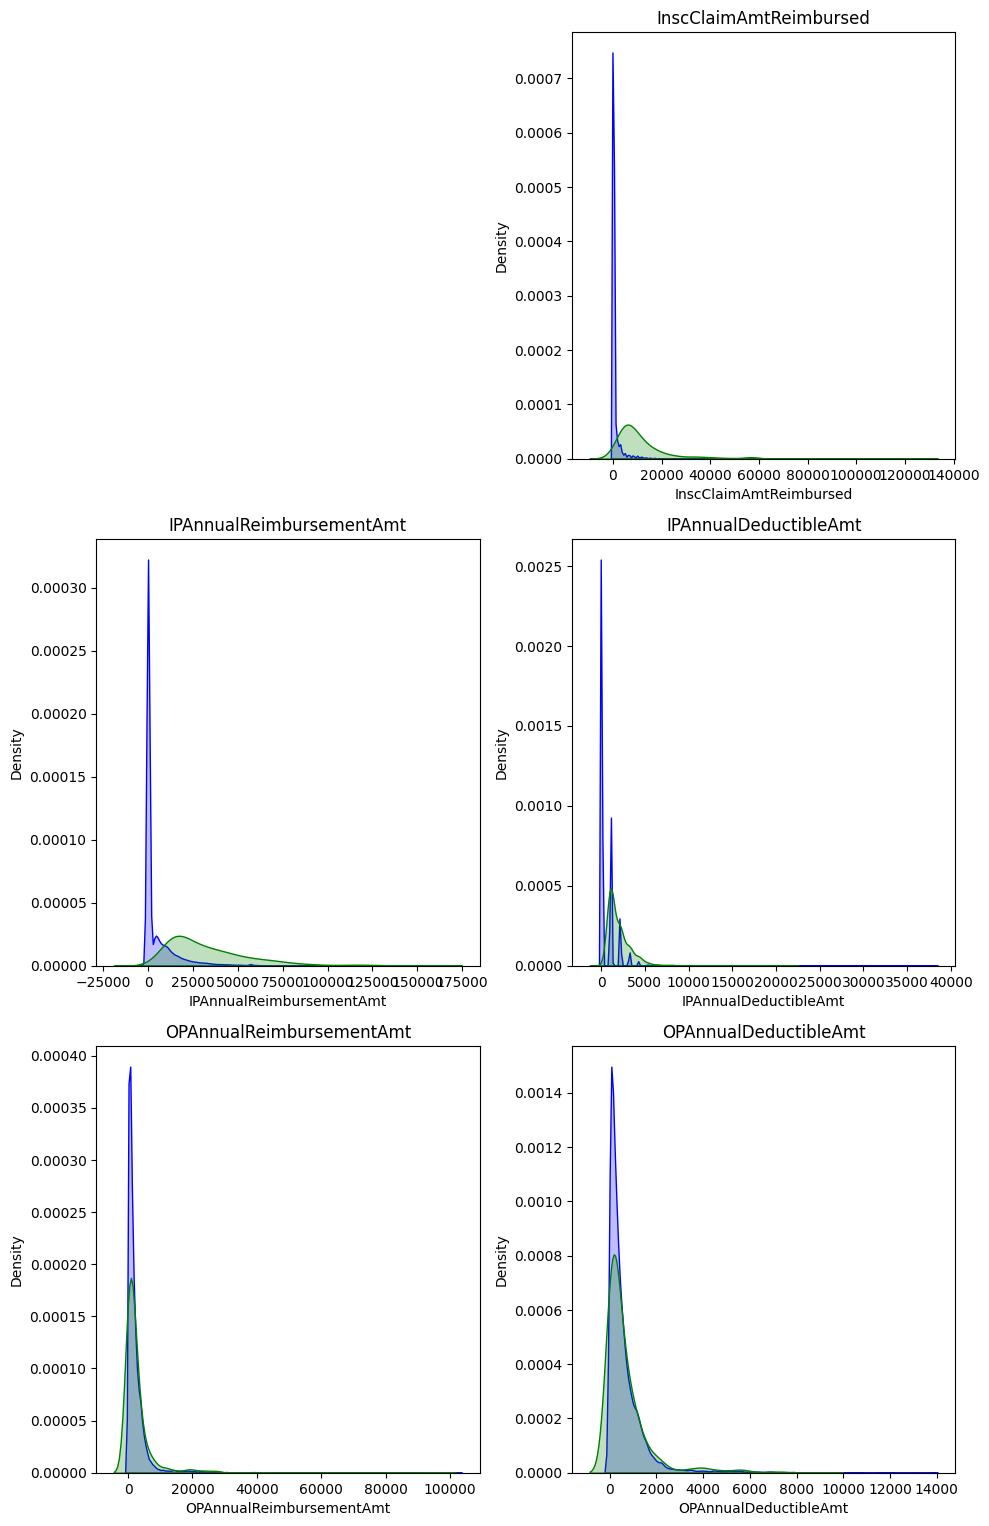

In [27]:
# Select reimbursement/payment columns to compare with DeductibleAmtPaid's distribution
selected_col =  ['DeductibleAmtPaid', 'InscClaimAmtReimbursed', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
            'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt']

# Temporarily create a column to replace 'DeductibleAmtPaid' missing values with 0, and present values with 1
patient_train['DeductibleAmtPaid_temp'] = patient_train['DeductibleAmtPaid'].apply(lambda x: 0 if pd.isnull(x) else 1)

num_rows = (len(selected_col) + 3) // 2  # Adjust based on the desired layout
num_cols = 2

plt.figure(figsize=(10, 5*num_rows), layout='tight')
for idx, column in enumerate(selected_col, start=1):
    if column != 'DeductibleAmtPaid':
        plt.subplot(num_rows, num_cols, idx)
        sns.kdeplot(patient_train[patient_train["DeductibleAmtPaid_temp"]==1][column], fill=True, color="blue", label="like")
        sns.kdeplot(patient_train[patient_train["DeductibleAmtPaid_temp"]==0][column], fill=True, color="green", label="dislike")
        plt.title(column)

plt.show()

From the plots above, we observe that missing values for `DeductibleAmtPaid` is associated with a rightwards skew of `InscClaimAmtReimbursed` and `IPAnnualReimbursementAmt`. This could suggest that missing values could be Missing Not At Random (MNAR), where observations who don't pay are those with higher reimbursements. (ie: They ran away with the money with first paying the deductible amount.)

To further confirm this, we will proceed to analyse the distribution between missing vs non missing `DeductibleAmtPaid` against fraudulent transactions.

<Axes: xlabel='DeductibleAmtPaid_temp', ylabel='count'>

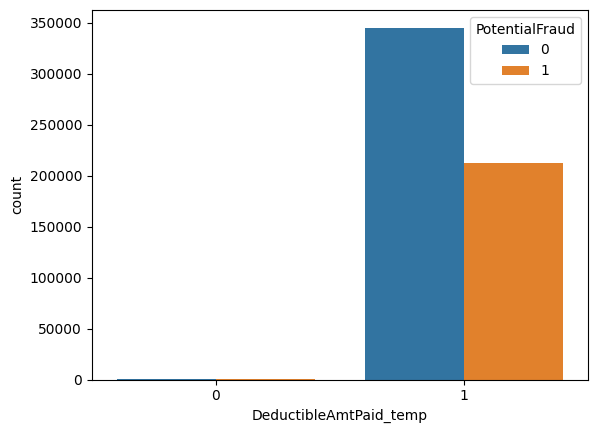

In [28]:
sns.countplot(data=patient_train, x='DeductibleAmtPaid_temp', hue='PotentialFraud')

As the plot above is too small for the missing `DeductibleAmtPaid`, we will plot again and zoom in on the missing values portion.

<Axes: xlabel='DeductibleAmtPaid_temp', ylabel='count'>

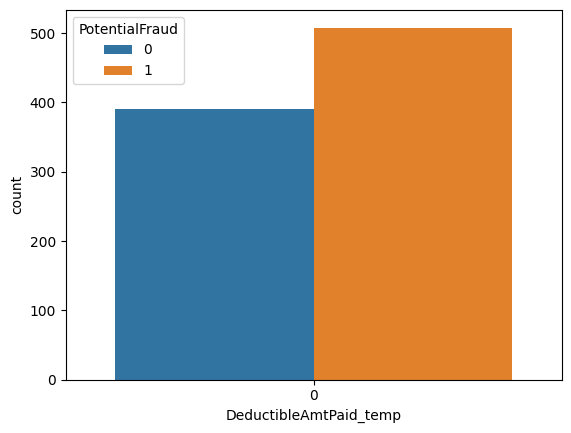

In [29]:
sns.countplot(data=patient_train[patient_train['DeductibleAmtPaid'].isna()], x='DeductibleAmtPaid_temp', hue='PotentialFraud')

We observe that trend for missing values `DeductibleAmtPaid` is the reverse of non-missing values of `DeductibleAmtPaid`. There may be a good chance that people actually ran away.

Hence, fair to impute the missing `DeductibleAmtPaid` values with 0.

In [30]:
# Drop temp columns
patient_train.drop(['DeductibleAmtPaid_temp'], axis=1, inplace=True)

# For DeductibleAmtPaid, assign missing amount to be 0
patient_train['DeductibleAmtPaid'].fillna(0, inplace=True)

#### Missing Values in Physician Codes
Finally, let us take a look at the missing values in the physician codes.

Similar to what was done for DeductibleAmtPaid, we will observe `AttendingPhysician`'s distribution of missing values in relation reimbursement/payment columns to determine if there are any links to fraud, and determine if it's suitable to impute the missing values with '0'

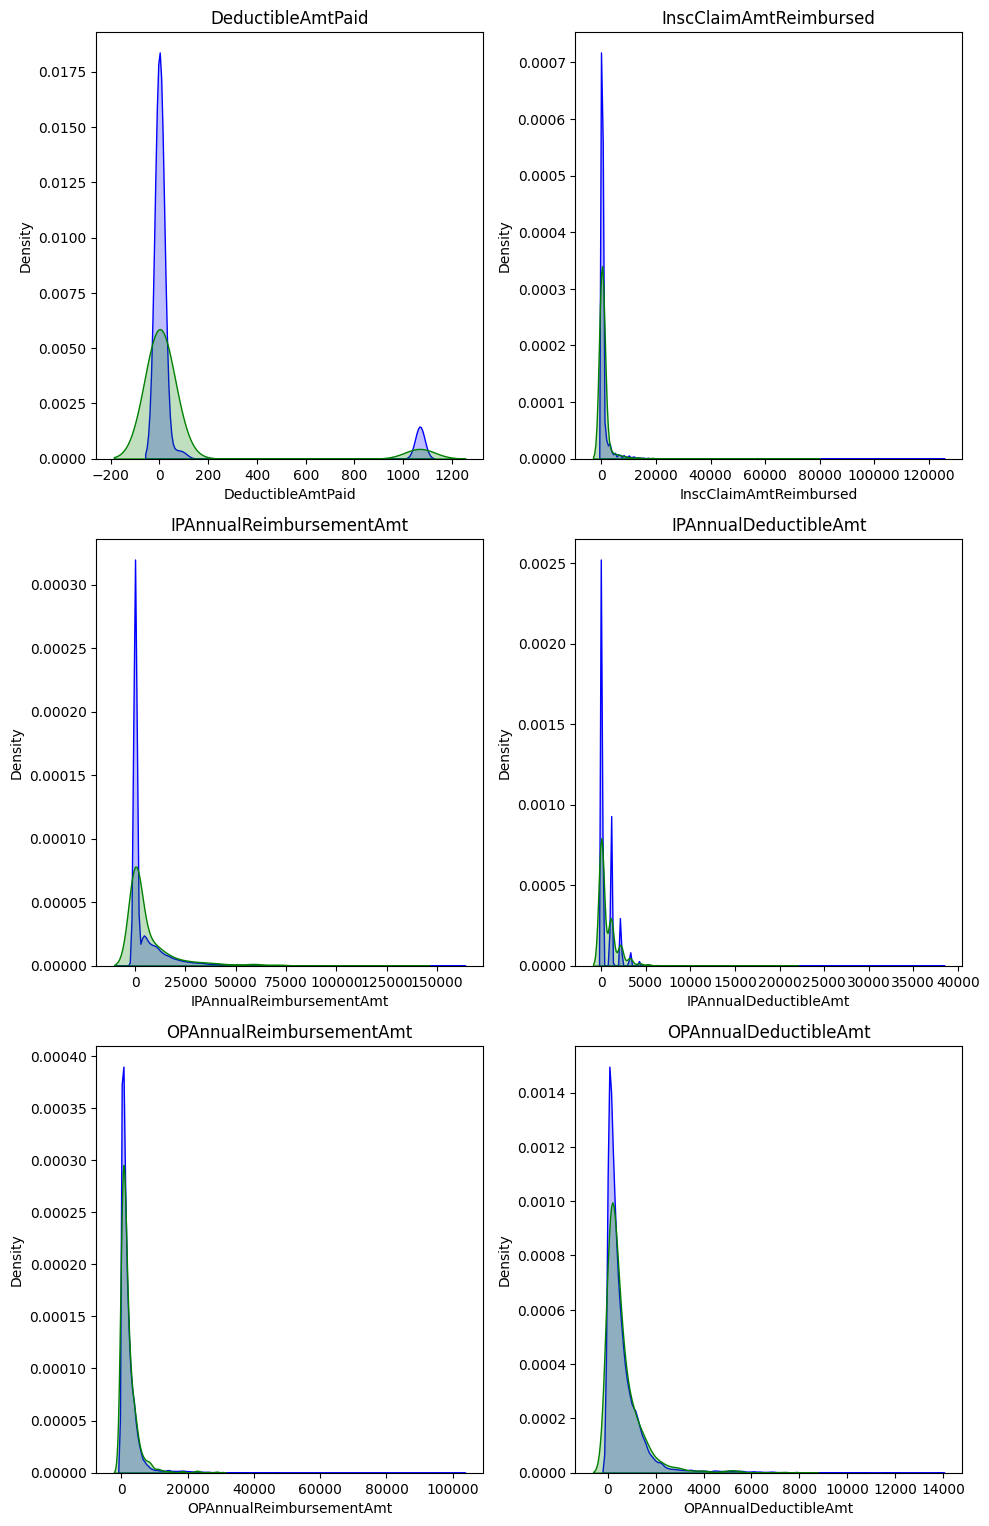

In [31]:
# Temporarily create a column to replace 'AttendingPhysician' missing values with 0, and present values with 1
patient_train['AttendingPhysician_temp'] = patient_train['AttendingPhysician'].apply(lambda x: 0 if pd.isnull(x) else 1)

num_rows = (len(selected_col) + 3) // 2  # Adjust based on the desired layout
num_cols = 2

plt.figure(figsize=(10, 5*num_rows), layout='tight')
for idx, column in enumerate(selected_col, start=1):
    plt.subplot(num_rows, num_cols, idx)
    sns.kdeplot(patient_train[patient_train["AttendingPhysician_temp"]==1][column], fill=True, color="blue", label="like")
    sns.kdeplot(patient_train[patient_train["AttendingPhysician_temp"]==0][column], fill=True, color="green", label="dislike")
    plt.title(column)

plt.show()

From the graphs above, we observe a somewhat similar distribution between `AttendingPhysician` (between missing and present) and the selected numerical columns that could be related to fraud. 

Finally, we check the distribution of missing attending physicians against in/outpatient


In [32]:
patient_train[patient_train['AttendingPhysician_temp']==0].groupby('is_inpatient').count()

# Drop temp column
patient_train.drop(['AttendingPhysician_temp'], axis=1, inplace=True)

Missing attending physicians belong to both in and outpatients, hence `AttendingPhysician` may be Missing Completely At Random (MCAR), and hence can be imputed with placeholder "0". We will do this later on when we frequency encode the physician columns.

Moving on, let us analyse the missing values for `OperatingPhysician`. We start by analysing if these missing rows are associated with outpatient. This is based on a trivial assumption we have that patients who do not stay in the hospital do not require surgery, hence is are Missing at Random.

In [33]:
patient_train[patient_train['OperatingPhysician'].isna()]['is_inpatient'].unique()

array([1, 0])

Operating Physicians are present for both inpatient and outpatient. 

Maybe Operating Physicians can operate on outpatients too. Hence we will check the distribution of missing vs non missing Operating Physicians on inpatient vs outpatients

<Axes: xlabel='OperatingPhysician_temp', ylabel='count'>

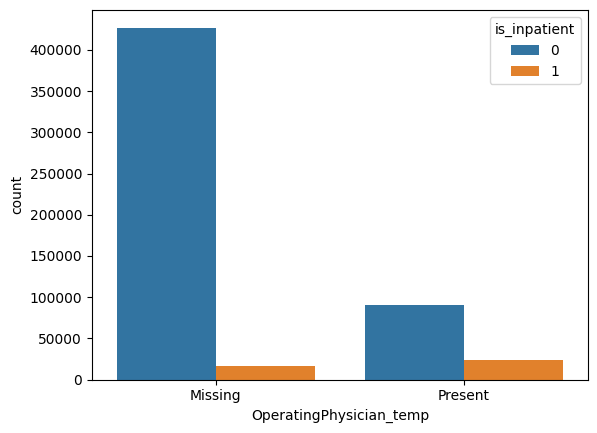

In [34]:
patient_train['OperatingPhysician_temp'] = patient_train['OperatingPhysician'].apply(lambda x: "Missing" if pd.isnull(x) else "Present")
sns.countplot(data=patient_train, x='OperatingPhysician_temp', hue='is_inpatient')

From the above, we can observe that most of the missing operating physicians are for outpatients, with similar trends to non missing observations. Hence, this seems to be Missing At Random, and can be imputed with '0'. We will do this later on when we frequency encode the physician columns.

In [35]:
# drop temp column
patient_train.drop(['OperatingPhysician_temp'], axis=1, inplace=True)

### 2.4 Categorical Encoding <a class="anchor" id="section_2_4"></a>
The following categorical data (Race, Gender, State, County) are already categorically encoded. So we convert them to categorical data type

In [36]:
# Convert the columns to categorical data type
categorical_columns = ['Race', 'Gender', 'State', 'County']

patient_train[categorical_columns] = patient_train[categorical_columns].astype('category')

### 2.5 Frequency Encoding <a class="anchor" id="section_2_5"></a>
Then we do frequency encoding for all the multi-label categorical features that are not yet encoded. They are the columns containing diagnosis codes, physician codes, procedure codes and diagnosis group codes.
- Note: All NaN values are encoded as '0' based on our justifications above.

In [37]:
# List of codes columns - for physicians, diagnosis and procedure
freq_encoding_cols = {
"Physician Codes" : ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician'],

"Diagnosis Codes" : ['ClmAdmitDiagnosisCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 
                   'ClmDiagnosisCode_4','ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 
                   'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9','ClmDiagnosisCode_10'],

"Procedure Codes" : ['ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 
                   'ClmProcedureCode_5'],

"Diagnosis Group Codes" : ['DiagnosisGroupCode']
}

In [38]:
# CountEncode each code group columns (Both Train and Test)
for k, code_cols in freq_encoding_cols.items():
    ec = ce.CountEncoder()
    # fit Encoder on stacked train data of each code group
    ec = ec.fit(patient_train[code_cols].stack(dropna=True).astype('O'))
    # transform each column of the code group
    for col in code_cols:
        patient_train[col + "_ce"] = ec.transform(patient_train[col].rename(0))
        patient_train[col + "_ce"] = patient_train[col + "_ce"].astype('category')
    print(f"Complete encoding for {k}")

Complete encoding for Physician Codes
Complete encoding for Diagnosis Codes
Complete encoding for Procedure Codes
Complete encoding for Diagnosis Group Codes


## 3. Exploratory Data Analysis <a class="anchor" id="chapter3"></a>
Now that our data is processed, we will proceed to explore the `PotentialFraud` proportion in different Features belonging to our training data.

### 3.1 Correlation Plot <a class="anchor" id="section_3_1"></a>
We start by first plotting the correlation matrix between all our numerical columns.

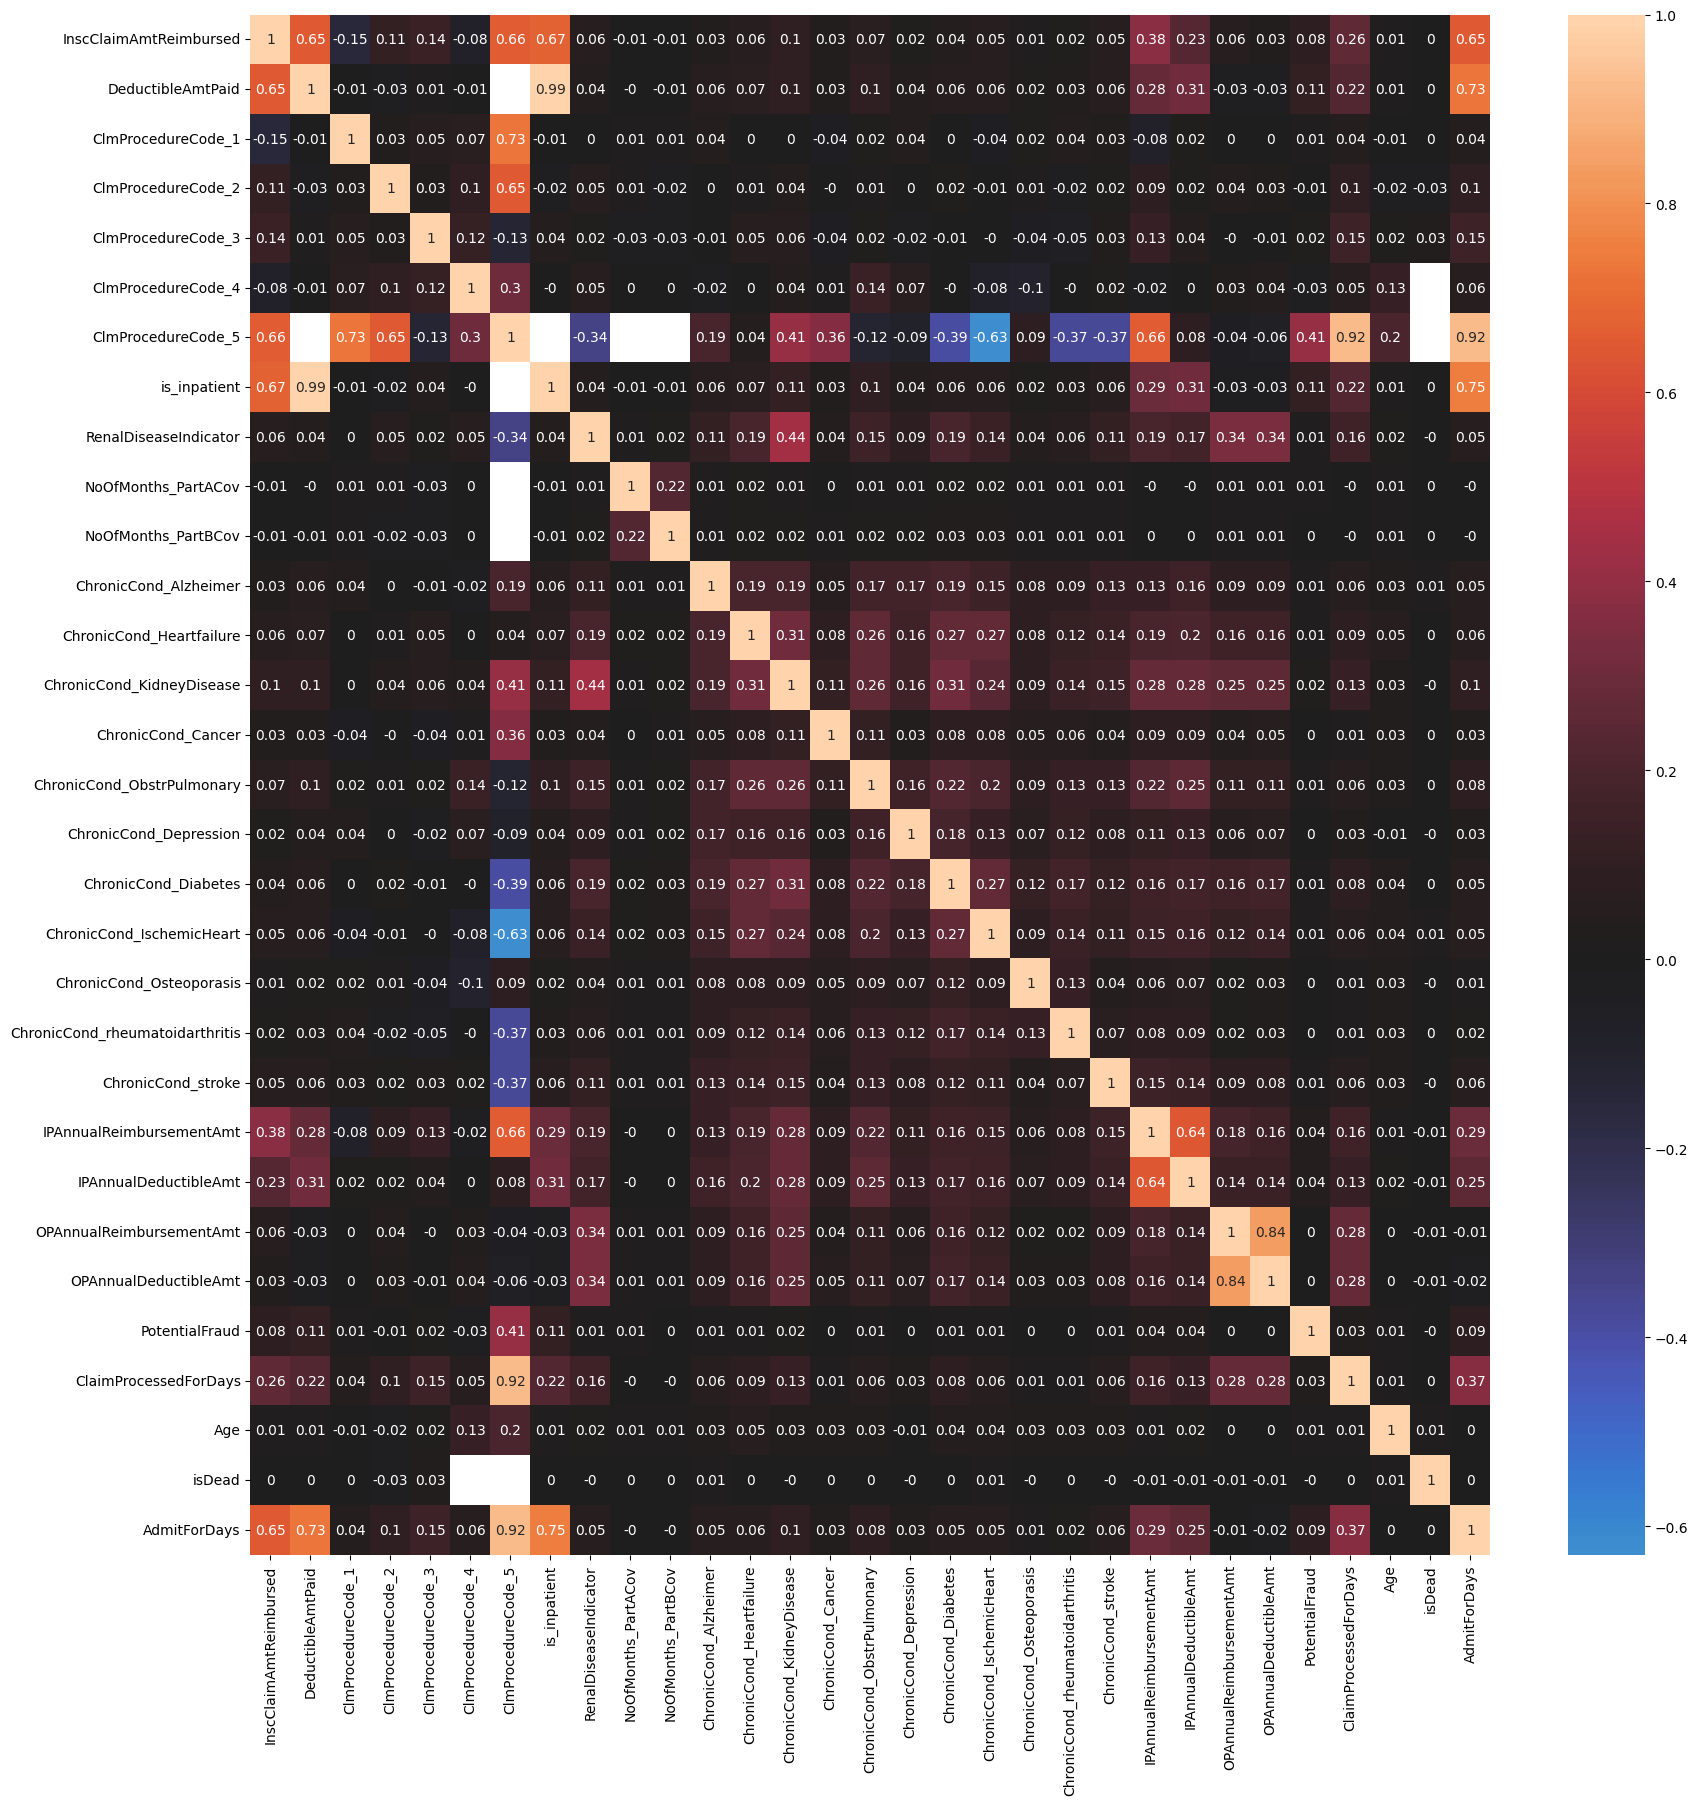

In [39]:
# Compute the correlation matrix for numerical columns
num_col = patient_train.select_dtypes(include=['number'])
corrmat =  num_col.corr()

# Set the size of the heatmap figure
plt.figure(figsize=(20, 20))

# Round the correlation values to 2 decimal places
rounded_corrmat = corrmat.round(2)

# Create a heatmap of the rounded correlation matrix
sns.heatmap(rounded_corrmat, annot=True, center=0)

# Display the heatmap
plt.show()

### 3.2 Overall Fraud Proportion <a class="anchor" id="section_3_2"> </a>
Next we take a look at the proportion of fraudulent to non-fraudulent claims.

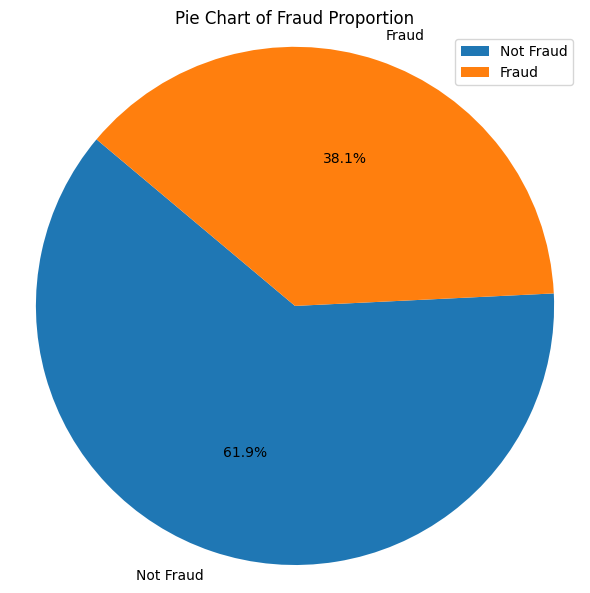

In [40]:
fraud_counts = patient_train['PotentialFraud'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6), layout='tight')
plt.pie(fraud_counts, labels=['Not Fraud', 'Fraud'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.

plt.title('Pie Chart of Fraud Proportion')
plt.legend()
plt.show()

Based on the pie chart, there is a mild imbalance in the percentage of fraud to non-fraud claims at about 60% to 40%.

### 3.3 Proportion by Categorical Features <a class="anchor" id="section_3_3"></a>
Next we examine the fraud distribution of claims across some of our categorical features.

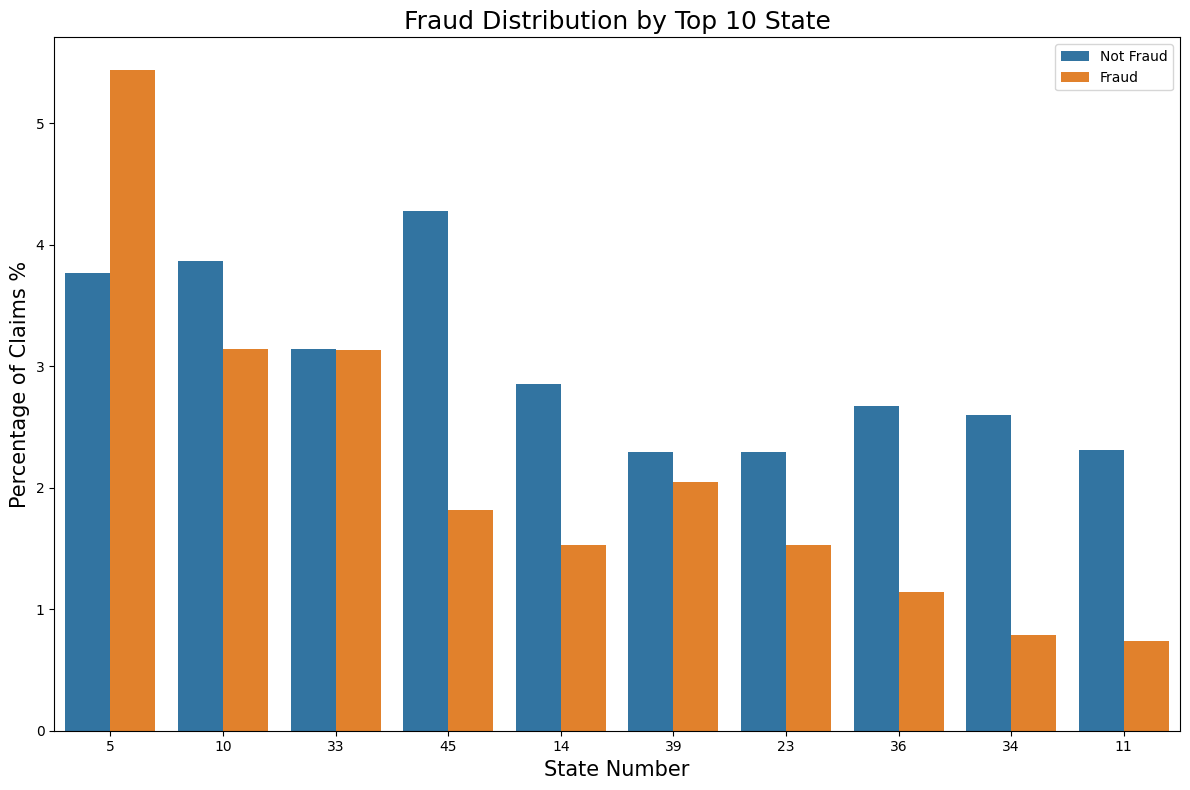

In [41]:
# We will first analyse the distribution of Frauds across the top 10 States with most claims
plt.figure(figsize=(12, 8), layout='tight')
sns.countplot(x='State',hue='PotentialFraud',data=patient_train, stat='percent'
              ,order=patient_train['State'].value_counts().iloc[:10].index)

plt.title("Fraud Distribution by Top 10 State",fontsize=18)
plt.xlabel("State Number",fontsize=15)
plt.ylabel("Percentage of Claims %",fontsize=15)
plt.legend(labels=['Not Fraud', 'Fraud'])
plt.show()

With the exception of State 5 which has the most number of claims, all other states appear to have a higher or equal proportion of fraudulent to non-fraudulent claims.

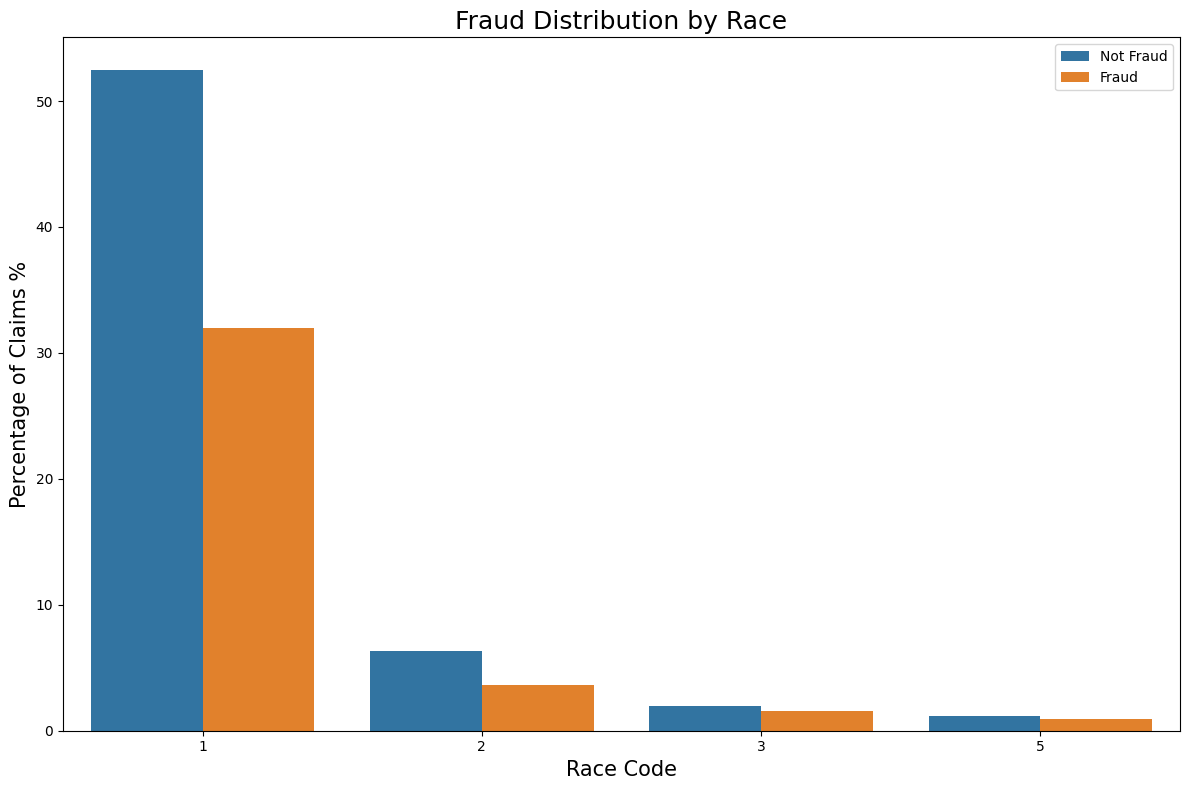

In [42]:
# Next we analyse the distribution of fraud by race.
plt.figure(figsize=(12, 8), layout='tight')

sns.countplot(x='Race',hue='PotentialFraud',data=patient_train, stat='percent'
              ,order=patient_train['Race'].value_counts().iloc[:10].index)

plt.title("Fraud Distribution by Race",fontsize=18)
plt.xlabel("Race Code",fontsize=15)
plt.ylabel("Percentage of Claims %",fontsize=15)
plt.legend(labels=['Not Fraud', 'Fraud'])
plt.show()


It can be observed that Race 1 contributes to the largest proportion of claims. We can also observe that there is no claims made by Race 4. Finally, all the distributions are relatively similar across the different races, with the difference in proportion of fraud to non-fraud decreasing from race 1 to race 5.

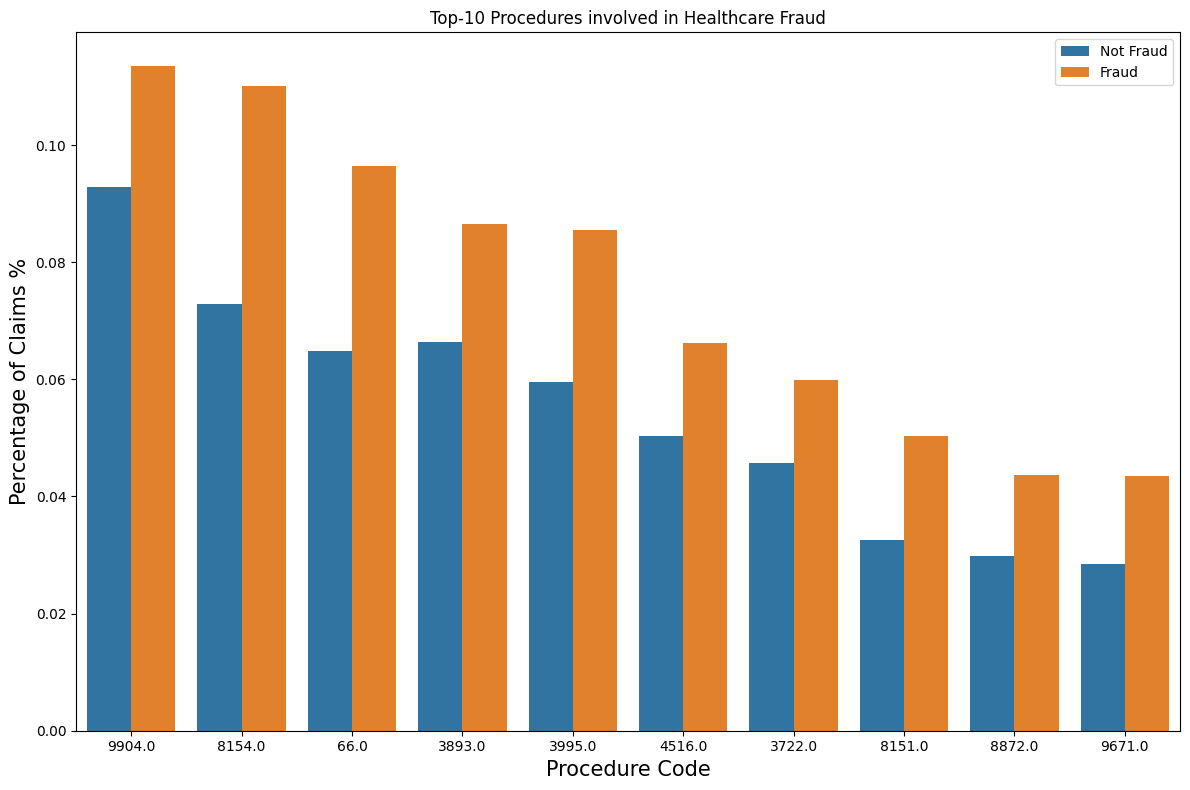

In [43]:
# Then we look at the distribution of Fraud across top 10 Procedures
# Note: As mentioned above, since procedure codes are likely to be filled in numerical order,
# as such we can use ClmProcedureCode_1 to analyse the top 10 procedures, since this column
# is likely to contain the bulk of procedure codes used.

plt.figure(figsize=(12, 8), layout='tight')
ax=sns.countplot(x='ClmProcedureCode_1',hue='PotentialFraud',data=patient_train, stat='percent'
              ,order=patient_train.ClmProcedureCode_1.value_counts().iloc[:10].index)

plt.title('Top-10 Procedures involved in Healthcare Fraud')
plt.xlabel("Procedure Code",fontsize=15)
plt.ylabel("Percentage of Claims %",fontsize=15)
plt.legend(labels=['Not Fraud', 'Fraud'])
    
plt.show()


Based on the finding above, it is interesting to observe that all top 10 codes have a larger proportion of fraudulent claims to non-fraudulent claims. This is likely due to the fact that fraudsters may want to blend in and file fraudulent claims for common procedures to avoid detection.

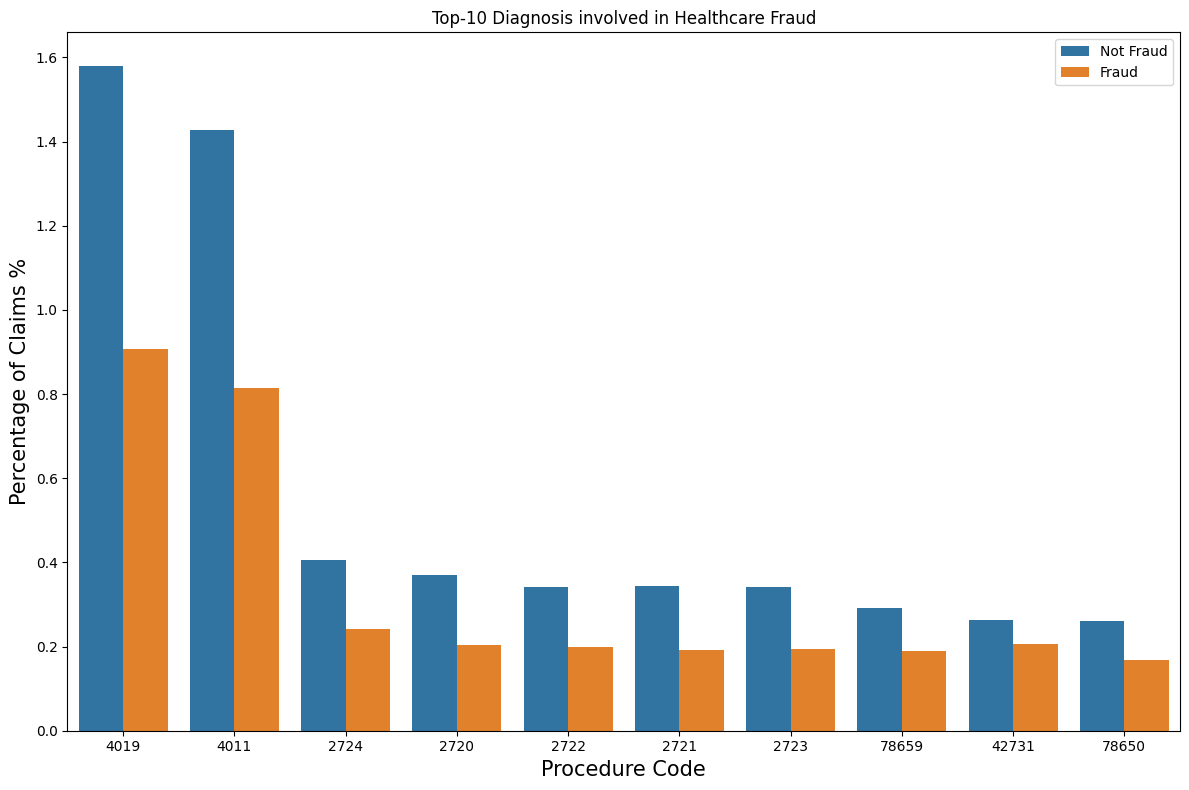

In [44]:
# Then we look at the distribution of Fraud across top 10 Diagnosis

plt.figure(figsize=(12, 8), layout='tight')
ax=sns.countplot(x='ClmDiagnosisCode_1',hue='PotentialFraud',data=patient_train, stat='percent'
              ,order=patient_train.ClmDiagnosisCode_1.value_counts().iloc[:10].index)

plt.title('Top-10 Diagnosis involved in Healthcare Fraud')
plt.xlabel("Procedure Code",fontsize=15)
plt.ylabel("Percentage of Claims %",fontsize=15)
plt.legend(labels=['Not Fraud', 'Fraud'])
    
plt.show()

All the top 10 diagnosis codes share similar distribution of fraud to non-fraud claims. The diagnosis code with the largest percentage of claims is 4019.

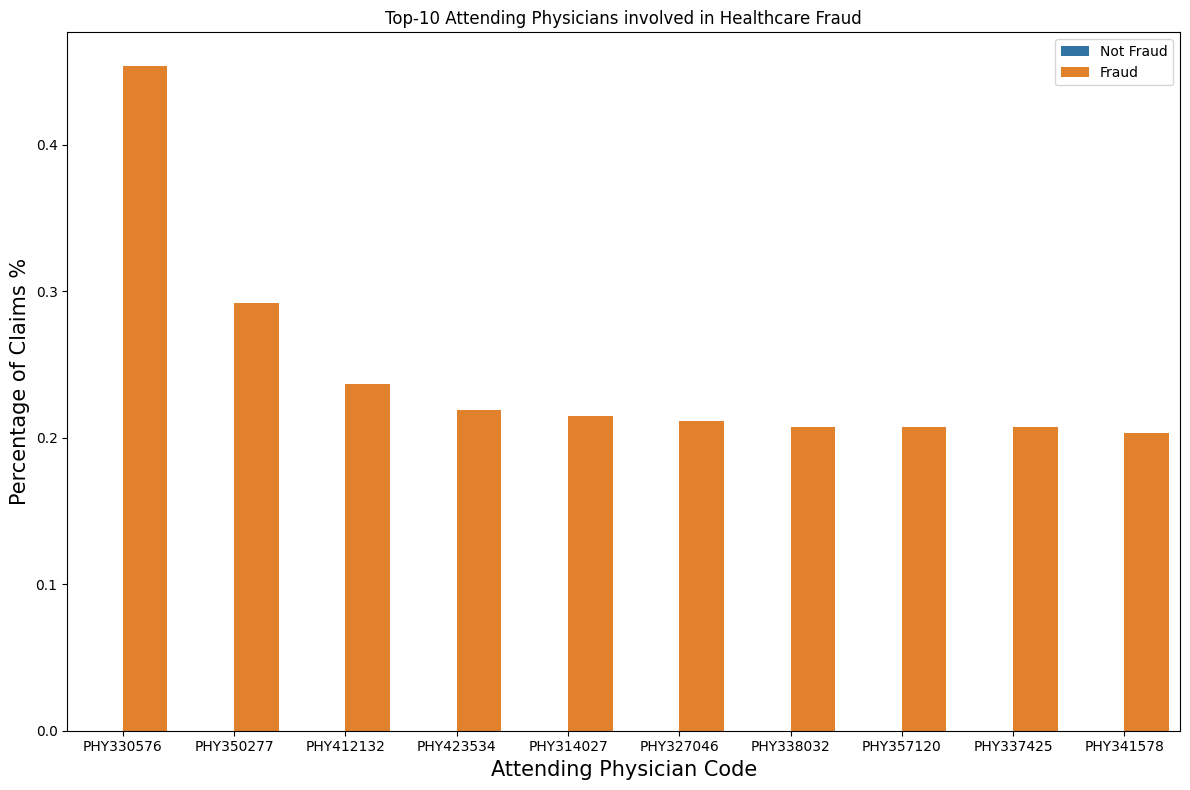

In [45]:
# Finally, we look at the distribution of Fraud across Attending Physicians

plt.figure(figsize=(12, 8), layout='tight')
ax=sns.countplot(x='AttendingPhysician',hue='PotentialFraud',data=patient_train, stat='percent'
              ,order=patient_train.AttendingPhysician.value_counts().iloc[:10].index)

plt.title('Top-10 Attending Physicians involved in Healthcare Fraud')
plt.xlabel("Attending Physician Code",fontsize=15)
plt.ylabel("Percentage of Claims %",fontsize=15)
plt.legend(labels=['Not Fraud', 'Fraud'])
    
plt.show()

It is interesting to observe from above that the top 10 attending physicians with the most claims are fraudsters.

## 4. Data Uploading <a class="anchor" id="chapter4"></a>
Now that we have completed our EDA and basic feature engineering, we will save all this data into a new csv file. This will allow us to have a fresh start with our cleaned data.

### 4.1 Obtaining Relevant Columns <a class="anchor" id="section_4_1"></a>
- Keep newly engineered features, categorical features, encoded features and scaled numerical features
- Ignore date columns, diagnosis, procedure and physician codes columns
- Upload to X_train, y_train and X_test csv file

In [46]:
relevant_cols = ['BeneID', 'ClaimID', 'Provider',
       'InscClaimAmtReimbursed', 'DeductibleAmtPaid',
       'is_inpatient', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'Age', 'isDead',
       'AdmitForDays', 'ClaimProcessedForDays', 'AttendingPhysician_ce',
       'OperatingPhysician_ce', 'OtherPhysician_ce',
       'ClmAdmitDiagnosisCode_ce', 'ClmDiagnosisCode_1_ce',
       'ClmDiagnosisCode_2_ce', 'ClmDiagnosisCode_3_ce',
       'ClmDiagnosisCode_4_ce', 'ClmDiagnosisCode_5_ce',
       'ClmDiagnosisCode_6_ce', 'ClmDiagnosisCode_7_ce',
       'ClmDiagnosisCode_8_ce', 'ClmDiagnosisCode_9_ce',
       'ClmDiagnosisCode_10_ce', 'ClmProcedureCode_1_ce',
       'ClmProcedureCode_2_ce', 'ClmProcedureCode_3_ce',
       'ClmProcedureCode_4_ce', 'ClmProcedureCode_5_ce', 'DiagnosisGroupCode_ce']
target_col = ['BeneID', 'Provider', 'PotentialFraud']

In [47]:
# X_train, y_train
X_train = patient_train[relevant_cols]
y_train = patient_train[target_col]

num_rows = X_train.shape[0]
split_index = num_rows // 2

# Split the DataFrame into two equal parts
X_train1 = X_train.iloc[:split_index]
X_train2 = X_train.iloc[split_index:]

# Save X_train, y_train to csv files
X_train1.to_csv('X_train1.csv', index=False)
X_train2.to_csv('X_train2.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

## 5. Automated Feature Engineering <a class="anchor" id="chapter5"></a>
As mentioned in the introduction, our labels are on fraudulent providers. As such, we will need to engineer new features from the claims data obtained above.

Instead of generating our features manually, we will utilise a technique known as automated feature engineering to help us generate more features. In particular, we will utilise deep feature synthesis (DFS) from the featuretools library to help us with this process. DFS applies aggregation and transformation operations on existing features and stacks them together to create new features. Subsequently, we can test and see the effectiveness of these new features in helping us to predict medicare fraud by provider.

### 5.1 Importing Preprocessed Datasets <a class="anchor" id="section_5_1"></a>
We start by importing our preprocessed datasets. 

In [48]:
# Load preprocessed datasets
X_train1 = pd.read_csv('X_train1.csv')
X_train2 = pd.read_csv('X_train2.csv')
y_labels = pd.read_csv('y_train.csv')
X_labeled = pd.concat([X_train1, X_train2], ignore_index=True) # Combine into 1 training set

# As labels were provided for fraudulent providers only, we will retain the providers in our y_labels only.
y_providers = y_labels[['Provider', 'PotentialFraud']].drop_duplicates(ignore_index=True)

# Next we drop the labels in X_labeled_full
X_full = X_labeled[X_labeled.columns.difference(['BeneID',])]

display(X_full.head())
display(y_providers.head())

,AdmitForDays,Age,AttendingPhysician_ce,ChronicCond_Alzheimer,ChronicCond_Cancer,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_Heartfailure,ChronicCond_IschemicHeart,ChronicCond_KidneyDisease,ChronicCond_ObstrPulmonary,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,ClaimID,ClaimProcessedForDays,ClmAdmitDiagnosisCode_ce,ClmDiagnosisCode_10_ce,ClmDiagnosisCode_1_ce,ClmDiagnosisCode_2_ce,ClmDiagnosisCode_3_ce,ClmDiagnosisCode_4_ce,ClmDiagnosisCode_5_ce,ClmDiagnosisCode_6_ce,ClmDiagnosisCode_7_ce,ClmDiagnosisCode_8_ce,ClmDiagnosisCode_9_ce,ClmProcedureCode_1_ce,ClmProcedureCode_2_ce,ClmProcedureCode_3_ce,ClmProcedureCode_4_ce,ClmProcedureCode_5_ce,County,DeductibleAmtPaid,DiagnosisGroupCode_ce,Gender,IPAnnualDeductibleAmt,IPAnnualReimbursementAmt,InscClaimAmtReimbursed,NoOfMonths_PartACov,NoOfMonths_PartBCov,OPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OperatingPhysician_ce,OtherPhysician_ce,Provider,Race,RenalDiseaseIndicator,State,isDead,is_inpatient
0,7.0,67.0,1.0,1,0,1,1,0,1,1,0,0,1,1,CLM46614,7,955.0,0.0,748.0,79788.0,4251.0,630.0,4673.0,6980.0,37270.0,341.0,5266.0,0.0,0.0,0.0,0.0,0.0,230,1068.0,129,1,3204,36000,26000,12,12,70,60,0.0,0.0,PRV55912,1,0,39,0.0,1
1,3.0,67.0,3.0,1,0,1,1,0,1,1,0,0,1,1,CLM66048,3,57.0,0.0,57.0,5182.0,3461.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,230,1068.0,16,1,3204,36000,5000,12,12,70,60,3.0,0.0,PRV55907,1,0,39,0.0,1
2,4.0,67.0,12.0,1,0,1,1,0,1,1,0,0,1,1,CLM68358,4,1041.0,0.0,170.0,550.0,3416.0,2177.0,836.0,2242.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230,1068.0,160,1,3204,36000,5000,12,12,70,60,0.0,14.0,PRV56046,1,0,39,0.0,1
3,9.0,96.0,55.0,0,0,1,1,1,0,1,0,0,1,1,CLM38412,9,360.0,0.0,2077.0,1423.0,630.0,2242.0,163.0,2941.0,412.0,5427.0,79788.0,100.0,0.0,0.0,0.0,0.0,360,1068.0,38,2,1068,5000,5000,12,12,320,250,12.0,15.0,PRV52405,2,0,1,0.0,1
4,18.0,72.0,2.0,0,0,1,0,1,1,1,1,0,0,0,CLM63689,18,1937.0,0.0,680.0,9099.0,292.0,5384.0,2765.0,6242.0,2442.0,580.0,831.0,854.0,0.0,0.0,0.0,0.0,780,1068.0,5,2,2136,21260,10000,12,12,100,120,5.0,0.0,PRV56614,1,1,45,0.0,1


,Provider,PotentialFraud
0,PRV55912,1
1,PRV55907,0
2,PRV56046,0
3,PRV52405,0
4,PRV56614,0


### 5.2 Creating EntitySets <a class="anchor" id="section_5_2"></a>

Next, we add our datasets into an entityset and map out their relationships. An EntitySet is a collection of dataframes and the relationship between each dataframe.

**Note**: As we have a mixture of numerical, categorical and boolean data, we will need to explicitly list the categorical and boolean data so that the appropriate operations can be performed on them during DFS.

In [49]:
# During the preprocessing stage, these are the list of numerical, categorical and boolean data
numerical_cols = [
    "AdmitForDays",
    "Age",
    "ClaimProcessedForDays",
    "DeductibleAmtPaid",
    "IPAnnualDeductibleAmt",
    "IPAnnualReimbursementAmt",
    "InscClaimAmtReimbursed",
    "NoOfMonths_PartACov",
    "NoOfMonths_PartBCov",
    "OPAnnualDeductibleAmt",
    "OPAnnualReimbursementAmt",
]
categorical_cols = [
    "AttendingPhysician_ce",
    "ClaimID",
    "ClmAdmitDiagnosisCode_ce",
    "ClmDiagnosisCode_10_ce",
    "ClmDiagnosisCode_1_ce",
    "ClmDiagnosisCode_2_ce",
    "ClmDiagnosisCode_3_ce",
    "ClmDiagnosisCode_4_ce",
    "ClmDiagnosisCode_5_ce",
    "ClmDiagnosisCode_6_ce",
    "ClmDiagnosisCode_7_ce",
    "ClmDiagnosisCode_8_ce",
    "ClmDiagnosisCode_9_ce",
    "ClmProcedureCode_1_ce",
    "ClmProcedureCode_2_ce",
    "ClmProcedureCode_3_ce",
    "ClmProcedureCode_4_ce",
    "ClmProcedureCode_5_ce",
    "County",
    "DiagnosisGroupCode_ce",
    "Gender",
    "OperatingPhysician_ce",
    "OtherPhysician_ce",
    "Provider",
    "Race",
    "State",
]
bool_cols = [
    "ChronicCond_Alzheimer",
    "ChronicCond_Cancer",
    "ChronicCond_Depression",
    "ChronicCond_Diabetes",
    "ChronicCond_Heartfailure",
    "ChronicCond_IschemicHeart",
    "ChronicCond_KidneyDisease",
    "ChronicCond_ObstrPulmonary",
    "ChronicCond_Osteoporasis",
    "ChronicCond_rheumatoidarthritis",
    "ChronicCond_stroke",
    "RenalDiseaseIndicator",
    "isDead",
    "is_inpatient",
    "RenalDiseaseIndicator",
]

In [50]:
# We will create a dictionary mapping for labelling the categorical and boolean data according to featuretools' documentation.
X_cat_bool_mapping = {
    cat_col: Categorical for cat_col in categorical_cols
}
X_cat_bool_mapping.update({
    bool_col: Boolean for bool_col in bool_cols
})

X_cat_bool_mapping

{'AttendingPhysician_ce': Categorical,
 'ClaimID': Categorical,
 'ClmAdmitDiagnosisCode_ce': Categorical,
 'ClmDiagnosisCode_10_ce': Categorical,
 'ClmDiagnosisCode_1_ce': Categorical,
 'ClmDiagnosisCode_2_ce': Categorical,
 'ClmDiagnosisCode_3_ce': Categorical,
 'ClmDiagnosisCode_4_ce': Categorical,
 'ClmDiagnosisCode_5_ce': Categorical,
 'ClmDiagnosisCode_6_ce': Categorical,
 'ClmDiagnosisCode_7_ce': Categorical,
 'ClmDiagnosisCode_8_ce': Categorical,
 'ClmDiagnosisCode_9_ce': Categorical,
 'ClmProcedureCode_1_ce': Categorical,
 'ClmProcedureCode_2_ce': Categorical,
 'ClmProcedureCode_3_ce': Categorical,
 'ClmProcedureCode_4_ce': Categorical,
 'ClmProcedureCode_5_ce': Categorical,
 'County': Categorical,
 'DiagnosisGroupCode_ce': Categorical,
 'Gender': Categorical,
 'OperatingPhysician_ce': Categorical,
 'OtherPhysician_ce': Categorical,
 'Provider': Categorical,
 'Race': Categorical,
 'State': Categorical,
 'ChronicCond_Alzheimer': Boolean,
 'ChronicCond_Cancer': Boolean,
 'Chronic

In [51]:
y_cat_bool_mapping = {
    'Provider' : Categorical,
}
y_cat_bool_mapping

{'Provider': Categorical}

In [52]:
# Each dataset added into the entityset requires an index column that can uniquely identify every row.
# Hence we will first find a column to use as index in X_full
print(X_full.nunique().sort_values(
    ascending=False).head())  # We will use ClaimID

ClaimID                     558211
Provider                      5410
IPAnnualReimbursementAmt      3004
OPAnnualReimbursementAmt      2078
ClmDiagnosisCode_1_ce          948
dtype: int64


In [53]:
# Add data to entityset
entityset = EntitySet(id="es")
entityset = entityset.add_dataframe(
    dataframe=X_full, dataframe_name="X", index="ClaimID",
    logical_types=X_cat_bool_mapping
)
entityset = entityset.add_dataframe(
    dataframe=y_providers, dataframe_name="y", index="Provider",
    logical_types=y_cat_bool_mapping
)

display(entityset)

Entityset: es
  DataFrames:
    X [Rows: 558211, Columns: 51]
    y [Rows: 5410, Columns: 2]
  Relationships:
    No relationships

In [54]:
# Next we outline the relationships between our dataframes
entityset = entityset.add_relationship(
    parent_dataframe_name='y',
    parent_column_name='Provider',
    child_dataframe_name='X',
    child_column_name='Provider'
)

display(entityset)

Entityset: es
  DataFrames:
    X [Rows: 558211, Columns: 51]
    y [Rows: 5410, Columns: 2]
  Relationships:
    X.Provider -> y.Provider

### 5.3 Deep Feature Synthesis <a class="anchor" id="section_5_3"></a>
Now that we have our entityset, we will carry out deep feature synthesis on our data to generate the new features that are aggregated on Provider.

In [55]:
# Now we run deep feature synthesis and create a feature matrix for each provider.
feature_matrix_providers, feature_defs = dfs(
    entityset=entityset, target_dataframe_name="y")
feature_matrix_providers_val, feature_defs_val = dfs(
    entityset=entityset, target_dataframe_name="y")

display(feature_matrix_providers.head())
print(feature_matrix_providers.shape)

,PotentialFraud,COUNT(X),MAX(X.AdmitForDays),MAX(X.Age),MAX(X.ClaimProcessedForDays),MAX(X.DeductibleAmtPaid),MAX(X.IPAnnualDeductibleAmt),MAX(X.IPAnnualReimbursementAmt),MAX(X.InscClaimAmtReimbursed),MAX(X.NoOfMonths_PartACov),MAX(X.NoOfMonths_PartBCov),MAX(X.OPAnnualDeductibleAmt),MAX(X.OPAnnualReimbursementAmt),MEAN(X.AdmitForDays),MEAN(X.Age),MEAN(X.ClaimProcessedForDays),MEAN(X.DeductibleAmtPaid),MEAN(X.IPAnnualDeductibleAmt),MEAN(X.IPAnnualReimbursementAmt),MEAN(X.InscClaimAmtReimbursed),MEAN(X.NoOfMonths_PartACov),MEAN(X.NoOfMonths_PartBCov),MEAN(X.OPAnnualDeductibleAmt),MEAN(X.OPAnnualReimbursementAmt),MIN(X.AdmitForDays),MIN(X.Age),MIN(X.ClaimProcessedForDays),MIN(X.DeductibleAmtPaid),MIN(X.IPAnnualDeductibleAmt),MIN(X.IPAnnualReimbursementAmt),MIN(X.InscClaimAmtReimbursed),MIN(X.NoOfMonths_PartACov),MIN(X.NoOfMonths_PartBCov),MIN(X.OPAnnualDeductibleAmt),MIN(X.OPAnnualReimbursementAmt),MODE(X.AttendingPhysician_ce),MODE(X.ClmAdmitDiagnosisCode_ce),MODE(X.ClmDiagnosisCode_10_ce),MODE(X.ClmDiagnosisCode_1_ce),MODE(X.ClmDiagnosisCode_2_ce),MODE(X.ClmDiagnosisCode_3_ce),MODE(X.ClmDiagnosisCode_4_ce),MODE(X.ClmDiagnosisCode_5_ce),MODE(X.ClmDiagnosisCode_6_ce),MODE(X.ClmDiagnosisCode_7_ce),MODE(X.ClmDiagnosisCode_8_ce),MODE(X.ClmDiagnosisCode_9_ce),MODE(X.ClmProcedureCode_1_ce),MODE(X.ClmProcedureCode_2_ce),MODE(X.ClmProcedureCode_3_ce),MODE(X.ClmProcedureCode_4_ce),MODE(X.ClmProcedureCode_5_ce),MODE(X.County),MODE(X.DiagnosisGroupCode_ce),MODE(X.Gender),MODE(X.OperatingPhysician_ce),MODE(X.OtherPhysician_ce),MODE(X.Race),MODE(X.State),NUM_UNIQUE(X.AttendingPhysician_ce),NUM_UNIQUE(X.ClmAdmitDiagnosisCode_ce),NUM_UNIQUE(X.ClmDiagnosisCode_10_ce),NUM_UNIQUE(X.ClmDiagnosisCode_1_ce),NUM_UNIQUE(X.ClmDiagnosisCode_2_ce),NUM_UNIQUE(X.ClmDiagnosisCode_3_ce),NUM_UNIQUE(X.ClmDiagnosisCode_4_ce),NUM_UNIQUE(X.ClmDiagnosisCode_5_ce),NUM_UNIQUE(X.ClmDiagnosisCode_6_ce),NUM_UNIQUE(X.ClmDiagnosisCode_7_ce),NUM_UNIQUE(X.ClmDiagnosisCode_8_ce),NUM_UNIQUE(X.ClmDiagnosisCode_9_ce),NUM_UNIQUE(X.ClmProcedureCode_1_ce),NUM_UNIQUE(X.ClmProcedureCode_2_ce),NUM_UNIQUE(X.ClmProcedureCode_3_ce),NUM_UNIQUE(X.ClmProcedureCode_4_ce),NUM_UNIQUE(X.ClmProcedureCode_5_ce),NUM_UNIQUE(X.County),NUM_UNIQUE(X.DiagnosisGroupCode_ce),NUM_UNIQUE(X.Gender),NUM_UNIQUE(X.OperatingPhysician_ce),NUM_UNIQUE(X.OtherPhysician_ce),NUM_UNIQUE(X.Race),NUM_UNIQUE(X.State),PERCENT_TRUE(X.ChronicCond_Alzheimer),PERCENT_TRUE(X.ChronicCond_Cancer),PERCENT_TRUE(X.ChronicCond_Depression),PERCENT_TRUE(X.ChronicCond_Diabetes),PERCENT_TRUE(X.ChronicCond_Heartfailure),PERCENT_TRUE(X.ChronicCond_IschemicHeart),PERCENT_TRUE(X.ChronicCond_KidneyDisease),PERCENT_TRUE(X.ChronicCond_ObstrPulmonary),PERCENT_TRUE(X.ChronicCond_Osteoporasis),PERCENT_TRUE(X.ChronicCond_rheumatoidarthritis),PERCENT_TRUE(X.ChronicCond_stroke),PERCENT_TRUE(X.RenalDiseaseIndicator),PERCENT_TRUE(X.isDead),PERCENT_TRUE(X.is_inpatient),SKEW(X.AdmitForDays),SKEW(X.Age),SKEW(X.ClaimProcessedForDays),SKEW(X.DeductibleAmtPaid),SKEW(X.IPAnnualDeductibleAmt),SKEW(X.IPAnnualReimbursementAmt),SKEW(X.InscClaimAmtReimbursed),SKEW(X.NoOfMonths_PartACov),SKEW(X.NoOfMonths_PartBCov),SKEW(X.OPAnnualDeductibleAmt),SKEW(X.OPAnnualReimbursementAmt),STD(X.AdmitForDays),STD(X.Age),STD(X.ClaimProcessedForDays),STD(X.DeductibleAmtPaid),STD(X.IPAnnualDeductibleAmt),STD(X.IPAnnualReimbursementAmt),STD(X.InscClaimAmtReimbursed),STD(X.NoOfMonths_PartACov),STD(X.NoOfMonths_PartBCov),STD(X.OPAnnualDeductibleAmt),STD(X.OPAnnualReimbursementAmt),SUM(X.AdmitForDays),SUM(X.Age),SUM(X.ClaimProcessedForDays),SUM(X.DeductibleAmtPaid),SUM(X.IPAnnualDeductibleAmt),SUM(X.IPAnnualReimbursementAmt),SUM(X.InscClaimAmtReimbursed),SUM(X.NoOfMonths_PartACov),SUM(X.NoOfMonths_PartBCov),SUM(X.OPAnnualDeductibleAmt),SUM(X.OPAnnualReimbursementAmt)
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV55912,1,107,28.0,101.0,28.0,1068.0,7204.0,72500.0,52000.0,12.0,12.0,8750.0,5

(5410, 130)


### 5.4 Feature Matrix Preprocessing <a class="anchor" id="section_5_4"></a>
As aggregation operations were performed on the data, our feature matrix may contain NaN in some columns. Let us see what they are and determine a suitable way to handle them.

In [56]:
print('Columns with NaN and Number of NaNs for Training Feature Matrix')
[print(i, v) for i, v in feature_matrix_providers.isna().sum().sort_values(ascending=False).items() if v > 0]

Columns with NaN and Number of NaNs for Training Feature Matrix
SKEW(X.Age) 440
SKEW(X.AdmitForDays) 440
SKEW(X.ClaimProcessedForDays) 440
SKEW(X.DeductibleAmtPaid) 440
SKEW(X.IPAnnualDeductibleAmt) 440
SKEW(X.IPAnnualReimbursementAmt) 440
SKEW(X.InscClaimAmtReimbursed) 440
SKEW(X.NoOfMonths_PartACov) 440
SKEW(X.NoOfMonths_PartBCov) 440
SKEW(X.OPAnnualDeductibleAmt) 440
SKEW(X.OPAnnualReimbursementAmt) 440
STD(X.IPAnnualReimbursementAmt) 240
STD(X.AdmitForDays) 240
STD(X.ClaimProcessedForDays) 240
STD(X.DeductibleAmtPaid) 240
STD(X.IPAnnualDeductibleAmt) 240
STD(X.Age) 240
STD(X.InscClaimAmtReimbursed) 240
STD(X.NoOfMonths_PartBCov) 240
STD(X.OPAnnualDeductibleAmt) 240
STD(X.OPAnnualReimbursementAmt) 240
STD(X.NoOfMonths_PartACov) 240


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

```We observe that all the NaN columns belong to those aggregated with STD (Standard Deviation) and Skew. For simplicity, we will impute them as 0s.```

In [57]:
feature_matrix_providers = feature_matrix_providers.replace(np.nan, 0)

### 5.5 Dropping Irrelevant Features <a class="anchor" id="section_5_5"></a>

Next, let us drop some highly null features, single_valued_features and highly correlated features. This is because they are likely to have low predictive power in helping us to predict fraud.

**Note:** Highly null and highly correlated features are defined as:

- A feature is highly null if >=95% of its values are null
- A pair of features is highly correlated if the pair share a correlation >=95%.


In [58]:
# # Remove irrelevant features
feature_matrix_providers = remove_highly_null_features(feature_matrix=feature_matrix_providers)
feature_matrix_providers = remove_single_value_features(feature_matrix=feature_matrix_providers)
feature_matrix_providers = remove_highly_correlated_features(feature_matrix=feature_matrix_providers)

print(feature_matrix_providers.shape) # 24 features dropped in total

(5410, 106)


### 5.6 Train-Test Split <a class="anchor" id="section_5_6"></a>
The last thing we need to do before building our models is to scale our data. This is to help balance the impact of all variables on the distance calculation and can help to improve the performance of our models.

However to avoid *data leakage*, we will need to prepare our scaler on the training data only and then use it to fit our test data. 

Thus we will first train-test split our data.

In [59]:
X = feature_matrix_providers.drop(labels='PotentialFraud', axis=1)
y = feature_matrix_providers.PotentialFraud
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4012)

In [60]:
# View X_train
display(X_train.head())
print(X_train.shape)

,COUNT(X),MAX(X.AdmitForDays),MAX(X.Age),MAX(X.ClaimProcessedForDays),MAX(X.DeductibleAmtPaid),MAX(X.IPAnnualDeductibleAmt),MAX(X.IPAnnualReimbursementAmt),MAX(X.InscClaimAmtReimbursed),MAX(X.NoOfMonths_PartACov),MAX(X.NoOfMonths_PartBCov),MAX(X.OPAnnualDeductibleAmt),MAX(X.OPAnnualReimbursementAmt),MEAN(X.AdmitForDays),MEAN(X.Age),MEAN(X.ClaimProcessedForDays),MEAN(X.DeductibleAmtPaid),MEAN(X.IPAnnualDeductibleAmt),MEAN(X.IPAnnualReimbursementAmt),MEAN(X.InscClaimAmtReimbursed),MEAN(X.NoOfMonths_PartACov),MEAN(X.NoOfMonths_PartBCov),MEAN(X.OPAnnualDeductibleAmt),MEAN(X.OPAnnualReimbursementAmt),MIN(X.AdmitForDays),MIN(X.Age),MIN(X.ClaimProcessedForDays),MIN(X.DeductibleAmtPaid),MIN(X.IPAnnualDeductibleAmt),MIN(X.IPAnnualReimbursementAmt),MIN(X.InscClaimAmtReimbursed),MIN(X.NoOfMonths_PartACov),MIN(X.NoOfMonths_PartBCov),MIN(X.OPAnnualDeductibleAmt),MIN(X.OPAnnualReimbursementAmt),MODE(X.AttendingPhysician_ce),MODE(X.ClmAdmitDiagnosisCode_ce),MODE(X.ClmDiagnosisCode_10_ce),MODE(X.ClmDiagnosisCode_1_ce),MODE(X.ClmDiagnosisCode_2_ce),MODE(X.ClmDiagnosisCode_3_ce),MODE(X.ClmDiagnosisCode_4_ce),MODE(X.ClmDiagnosisCode_5_ce),MODE(X.ClmDiagnosisCode_6_ce),MODE(X.ClmDiagnosisCode_7_ce),MODE(X.ClmDiagnosisCode_8_ce),MODE(X.ClmDiagnosisCode_9_ce),MODE(X.ClmProcedureCode_1_ce),MODE(X.ClmProcedureCode_2_ce),MODE(X.ClmProcedureCode_3_ce),MODE(X.County),MODE(X.DiagnosisGroupCode_ce),MODE(X.Gender),MODE(X.OperatingPhysician_ce),MODE(X.OtherPhysician_ce),MODE(X.Race),MODE(X.State),NUM_UNIQUE(X.AttendingPhysician_ce),NUM_UNIQUE(X.ClmAdmitDiagnosisCode_ce),NUM_UNIQUE(X.ClmDiagnosisCode_10_ce),NUM_UNIQUE(X.ClmDiagnosisCode_1_ce),NUM_UNIQUE(X.ClmProcedureCode_1_ce),NUM_UNIQUE(X.ClmProcedureCode_2_ce),NUM_UNIQUE(X.ClmProcedureCode_3_ce),NUM_UNIQUE(X.ClmProcedureCode_4_ce),NUM_UNIQUE(X.ClmProcedureCode_5_ce),NUM_UNIQUE(X.County),NUM_UNIQUE(X.Gender),NUM_UNIQUE(X.Race),NUM_UNIQUE(X.State),PERCENT_TRUE(X.ChronicCond_Alzheimer),PERCENT_TRUE(X.ChronicCond_Cancer),PERCENT_TRUE(X.ChronicCond_Depression),PERCENT_TRUE(X.ChronicCond_Diabetes),PERCENT_TRUE(X.ChronicCond_Heartfailure),PERCENT_TRUE(X.ChronicCond_IschemicHeart),PERCENT_TRUE(X.ChronicCond_KidneyDisease),PERCENT_TRUE(X.ChronicCond_ObstrPulmonary),PERCENT_TRUE(X.ChronicCond_Osteoporasis),PERCENT_TRUE(X.ChronicCond_rheumatoidarthritis),PERCENT_TRUE(X.ChronicCond_stroke),PERCENT_TRUE(X.RenalDiseaseIndicator),PERCENT_TRUE(X.isDead),SKEW(X.AdmitForDays),SKEW(X.Age),SKEW(X.ClaimProcessedForDays),SKEW(X.DeductibleAmtPaid),SKEW(X.IPAnnualDeductibleAmt),SKEW(X.IPAnnualReimbursementAmt),SKEW(X.InscClaimAmtReimbursed),SKEW(X.NoOfMonths_PartACov),SKEW(X.NoOfMonths_PartBCov),SKEW(X.OPAnnualDeductibleAmt),SKEW(X.OPAnnualReimbursementAmt),STD(X.AdmitForDays),STD(X.Age),STD(X.ClaimProcessedForDays),STD(X.DeductibleAmtPaid),STD(X.IPAnnualDeductibleAmt),STD(X.IPAnnualReimbursementAmt),STD(X.InscClaimAmtReimbursed),STD(X.NoOfMonths_PartACov),STD(X.NoOfMonths_PartBCov),STD(X.OPAnnualDeductibleAmt),STD(X.OPAnnualReimbursementAmt),SUM(X.AdmitForDays)
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51426,206,14.0,95.0,21.0,1068.0,20068.0,68100.0,49000.0,12.0,12.0,4560.0,22990.0,0.228155,72.975728,2.135922,33.825243,698.116505,3537.572816,704.368932,12.000000,12.000000,615.922330,2036.359223,0.0,41.0,1.0,0.0,0.0,0.0,0.0,12.0,12.0,0.0,0.0,82.0,0.0,0.0,79788.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,670,517737,2,0.0,0.0,1,5,15,29,3,161,5,1,1,1,1,19,2,4,1,0.495146,0.199029,0.38835,0.776699,0.621359,0.762136,0.456311,0.257282,0.422330,0.262136,0.101942,0.145631,0.014563,7.442376,-0.487509,3.900689,5.586868,6.569205,3.969250,10.244355,0.000000,0.000000,2.075813,4.456427,1.468825,13.370313,4.090557,180.138831,2792.615982,8977.516139,3893.965731,0.000000,0.000000,615.510792,2412.094495,47.0
PRV55291,6,0.0,86.0,1.0,0.0,2136.0,11160.0,1700.0,12.0,12.0,1850.0,5620.0,0.000000,79.500000,1.000000,0.000000,712.000000,4753.333333,365.000000,12.000000,12.000000,1

(4328, 105)


In [61]:
# View y_train
display(y_train.head())
print(y_train.shape)

Provider
PRV51426    1
PRV55291    0
PRV55993    0
PRV55749    0
PRV52789    0
Name: PotentialFraud, dtype: int64

(4328,)


In [62]:
# View X_test
display(X_test.head())
print(X_test.shape)

,COUNT(X),MAX(X.AdmitForDays),MAX(X.Age),MAX(X.ClaimProcessedForDays),MAX(X.DeductibleAmtPaid),MAX(X.IPAnnualDeductibleAmt),MAX(X.IPAnnualReimbursementAmt),MAX(X.InscClaimAmtReimbursed),MAX(X.NoOfMonths_PartACov),MAX(X.NoOfMonths_PartBCov),MAX(X.OPAnnualDeductibleAmt),MAX(X.OPAnnualReimbursementAmt),MEAN(X.AdmitForDays),MEAN(X.Age),MEAN(X.ClaimProcessedForDays),MEAN(X.DeductibleAmtPaid),MEAN(X.IPAnnualDeductibleAmt),MEAN(X.IPAnnualReimbursementAmt),MEAN(X.InscClaimAmtReimbursed),MEAN(X.NoOfMonths_PartACov),MEAN(X.NoOfMonths_PartBCov),MEAN(X.OPAnnualDeductibleAmt),MEAN(X.OPAnnualReimbursementAmt),MIN(X.AdmitForDays),MIN(X.Age),MIN(X.ClaimProcessedForDays),MIN(X.DeductibleAmtPaid),MIN(X.IPAnnualDeductibleAmt),MIN(X.IPAnnualReimbursementAmt),MIN(X.InscClaimAmtReimbursed),MIN(X.NoOfMonths_PartACov),MIN(X.NoOfMonths_PartBCov),MIN(X.OPAnnualDeductibleAmt),MIN(X.OPAnnualReimbursementAmt),MODE(X.AttendingPhysician_ce),MODE(X.ClmAdmitDiagnosisCode_ce),MODE(X.ClmDiagnosisCode_10_ce),MODE(X.ClmDiagnosisCode_1_ce),MODE(X.ClmDiagnosisCode_2_ce),MODE(X.ClmDiagnosisCode_3_ce),MODE(X.ClmDiagnosisCode_4_ce),MODE(X.ClmDiagnosisCode_5_ce),MODE(X.ClmDiagnosisCode_6_ce),MODE(X.ClmDiagnosisCode_7_ce),MODE(X.ClmDiagnosisCode_8_ce),MODE(X.ClmDiagnosisCode_9_ce),MODE(X.ClmProcedureCode_1_ce),MODE(X.ClmProcedureCode_2_ce),MODE(X.ClmProcedureCode_3_ce),MODE(X.County),MODE(X.DiagnosisGroupCode_ce),MODE(X.Gender),MODE(X.OperatingPhysician_ce),MODE(X.OtherPhysician_ce),MODE(X.Race),MODE(X.State),NUM_UNIQUE(X.AttendingPhysician_ce),NUM_UNIQUE(X.ClmAdmitDiagnosisCode_ce),NUM_UNIQUE(X.ClmDiagnosisCode_10_ce),NUM_UNIQUE(X.ClmDiagnosisCode_1_ce),NUM_UNIQUE(X.ClmProcedureCode_1_ce),NUM_UNIQUE(X.ClmProcedureCode_2_ce),NUM_UNIQUE(X.ClmProcedureCode_3_ce),NUM_UNIQUE(X.ClmProcedureCode_4_ce),NUM_UNIQUE(X.ClmProcedureCode_5_ce),NUM_UNIQUE(X.County),NUM_UNIQUE(X.Gender),NUM_UNIQUE(X.Race),NUM_UNIQUE(X.State),PERCENT_TRUE(X.ChronicCond_Alzheimer),PERCENT_TRUE(X.ChronicCond_Cancer),PERCENT_TRUE(X.ChronicCond_Depression),PERCENT_TRUE(X.ChronicCond_Diabetes),PERCENT_TRUE(X.ChronicCond_Heartfailure),PERCENT_TRUE(X.ChronicCond_IschemicHeart),PERCENT_TRUE(X.ChronicCond_KidneyDisease),PERCENT_TRUE(X.ChronicCond_ObstrPulmonary),PERCENT_TRUE(X.ChronicCond_Osteoporasis),PERCENT_TRUE(X.ChronicCond_rheumatoidarthritis),PERCENT_TRUE(X.ChronicCond_stroke),PERCENT_TRUE(X.RenalDiseaseIndicator),PERCENT_TRUE(X.isDead),SKEW(X.AdmitForDays),SKEW(X.Age),SKEW(X.ClaimProcessedForDays),SKEW(X.DeductibleAmtPaid),SKEW(X.IPAnnualDeductibleAmt),SKEW(X.IPAnnualReimbursementAmt),SKEW(X.InscClaimAmtReimbursed),SKEW(X.NoOfMonths_PartACov),SKEW(X.NoOfMonths_PartBCov),SKEW(X.OPAnnualDeductibleAmt),SKEW(X.OPAnnualReimbursementAmt),STD(X.AdmitForDays),STD(X.Age),STD(X.ClaimProcessedForDays),STD(X.DeductibleAmtPaid),STD(X.IPAnnualDeductibleAmt),STD(X.IPAnnualReimbursementAmt),STD(X.InscClaimAmtReimbursed),STD(X.NoOfMonths_PartACov),STD(X.NoOfMonths_PartBCov),STD(X.OPAnnualDeductibleAmt),STD(X.OPAnnualReimbursementAmt),SUM(X.AdmitForDays)
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV53114,29,36.0,98.0,36.0,1068.0,3204.0,102000.0,102000.0,12.0,12.0,1900.0,86980.0,3.931034,74.793103,5.172414,477.344828,1325.793103,25447.931034,12575.172414,12.000000,12.000000,487.379310,8350.344828,0.0,51.0,1.0,0.0,0.0,0.0,0.0,12.0,12.0,0.0,0.0,9.0,0.0,0.0,650.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550,517737,2,0.0,0.0,1,17,7,15,1,28,11,3,2,1,1,9,2,1,1,0.482759,0.172414,0.586207,0.862069,0.586207,0.793103,0.655172,0.379310,0.379310,0.517241,0.137931,0.172414,0.0,3.383683,0.179660,2.937528,0.225630,0.368673,1.368225,2.919764,0.000000,0.000000,1.291813,3.461433,7.255200,10.997985,7.569058,531.006879,1164.881643,30476.253212,24303.470449,0.000000,0.000000,514.601053,22022.933417,114.0
PRV55885,8,0.0,89.0,1.0,100.0,1068.0,5000.0,1000.0,12.0,12.0,1640.0,4180.0,0.000000,75.125000,1.000000,12.500000,133.500000,625.000000,201.250000,12.000000,10.500000,4

(1082, 105)


In [63]:
# View y_test
display(y_test.head())
print(y_test.shape)

Provider
PRV53114    1
PRV55885    0
PRV57315    0
PRV54674    0
PRV52118    0
Name: PotentialFraud, dtype: int64

(1082,)


### 5.7 Data Scaling <a class="anchor" id="section_5_7"></a>
Now that we have our train and test set, we will proceed to scale our data using MinMax scaling. We have chosen MinMax scaling as it preserves the original distribution and outliers in our data, which are critical information for predicting fraud.

In [64]:
# Initiate a Scaler
minmaxScaler = MinMaxScaler()

# Fit the scaler on train data
cols_to_scale = X_train.columns.difference(['ClaimID', 'Provider'])
minmaxScaler.fit(X_train[cols_to_scale])

# Transform train and test data
X_train[cols_to_scale] = minmaxScaler.transform(X_train[cols_to_scale])
X_test[cols_to_scale] = minmaxScaler.transform(X_test[cols_to_scale])

# Unsupervised Learning -- Clustering

3 types of clustering will be employed, with the distortion score being used to determine the best model of the 3.


_____________________________________________________________________________________________________________________
### Types of clustering:

Kmeans Clustering

Agglomerative clustering

_____________________________________________________________________________________________________________________

The purpose of clustering is to find groups of observations with similar characteristics. Hence, target variable potential fraud will be left inside the input feature matrix, where clusters with 'Potential Fraud' closer to 1.0 may have characteristics relevant to fraudulent activity. Additionally, since all clustering methods aforementioned are unsupervised learning, there will be no Y (target) datasets. The purpose of these models are to identify sets of suspicious characteristics associated with fraud, contrary to non-fraudulent observations/ clusters.

## Clustering without PCA dimensionality reduction

In [77]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D projection

In [67]:
# for clustering purposes, join back the target values to the training set as explained above
# will be dropped again during MLP
X_train['PotentialFraud'] =  y_train
X_train.head()

,COUNT(X),MAX(X.AdmitForDays),MAX(X.Age),MAX(X.ClaimProcessedForDays),MAX(X.DeductibleAmtPaid),MAX(X.IPAnnualDeductibleAmt),MAX(X.IPAnnualReimbursementAmt),MAX(X.InscClaimAmtReimbursed),MAX(X.NoOfMonths_PartACov),MAX(X.NoOfMonths_PartBCov),MAX(X.OPAnnualDeductibleAmt),MAX(X.OPAnnualReimbursementAmt),MEAN(X.AdmitForDays),MEAN(X.Age),MEAN(X.ClaimProcessedForDays),MEAN(X.DeductibleAmtPaid),MEAN(X.IPAnnualDeductibleAmt),MEAN(X.IPAnnualReimbursementAmt),MEAN(X.InscClaimAmtReimbursed),MEAN(X.NoOfMonths_PartACov),MEAN(X.NoOfMonths_PartBCov),MEAN(X.OPAnnualDeductibleAmt),MEAN(X.OPAnnualReimbursementAmt),MIN(X.AdmitForDays),MIN(X.Age),MIN(X.ClaimProcessedForDays),MIN(X.DeductibleAmtPaid),MIN(X.IPAnnualDeductibleAmt),MIN(X.IPAnnualReimbursementAmt),MIN(X.InscClaimAmtReimbursed),MIN(X.NoOfMonths_PartACov),MIN(X.NoOfMonths_PartBCov),MIN(X.OPAnnualDeductibleAmt),MIN(X.OPAnnualReimbursementAmt),MODE(X.AttendingPhysician_ce),MODE(X.ClmAdmitDiagnosisCode_ce),MODE(X.ClmDiagnosisCode_10_ce),MODE(X.ClmDiagnosisCode_1_ce),MODE(X.ClmDiagnosisCode_2_ce),MODE(X.ClmDiagnosisCode_3_ce),MODE(X.ClmDiagnosisCode_4_ce),MODE(X.ClmDiagnosisCode_5_ce),MODE(X.ClmDiagnosisCode_6_ce),MODE(X.ClmDiagnosisCode_7_ce),MODE(X.ClmDiagnosisCode_8_ce),MODE(X.ClmDiagnosisCode_9_ce),MODE(X.ClmProcedureCode_1_ce),MODE(X.ClmProcedureCode_2_ce),MODE(X.ClmProcedureCode_3_ce),MODE(X.County),MODE(X.DiagnosisGroupCode_ce),MODE(X.Gender),MODE(X.OperatingPhysician_ce),MODE(X.OtherPhysician_ce),MODE(X.Race),MODE(X.State),NUM_UNIQUE(X.AttendingPhysician_ce),NUM_UNIQUE(X.ClmAdmitDiagnosisCode_ce),NUM_UNIQUE(X.ClmDiagnosisCode_10_ce),NUM_UNIQUE(X.ClmDiagnosisCode_1_ce),NUM_UNIQUE(X.ClmProcedureCode_1_ce),NUM_UNIQUE(X.ClmProcedureCode_2_ce),NUM_UNIQUE(X.ClmProcedureCode_3_ce),NUM_UNIQUE(X.ClmProcedureCode_4_ce),NUM_UNIQUE(X.ClmProcedureCode_5_ce),NUM_UNIQUE(X.County),NUM_UNIQUE(X.Gender),NUM_UNIQUE(X.Race),NUM_UNIQUE(X.State),PERCENT_TRUE(X.ChronicCond_Alzheimer),PERCENT_TRUE(X.ChronicCond_Cancer),PERCENT_TRUE(X.ChronicCond_Depression),PERCENT_TRUE(X.ChronicCond_Diabetes),PERCENT_TRUE(X.ChronicCond_Heartfailure),PERCENT_TRUE(X.ChronicCond_IschemicHeart),PERCENT_TRUE(X.ChronicCond_KidneyDisease),PERCENT_TRUE(X.ChronicCond_ObstrPulmonary),PERCENT_TRUE(X.ChronicCond_Osteoporasis),PERCENT_TRUE(X.ChronicCond_rheumatoidarthritis),PERCENT_TRUE(X.ChronicCond_stroke),PERCENT_TRUE(X.RenalDiseaseIndicator),PERCENT_TRUE(X.isDead),SKEW(X.AdmitForDays),SKEW(X.Age),SKEW(X.ClaimProcessedForDays),SKEW(X.DeductibleAmtPaid),SKEW(X.IPAnnualDeductibleAmt),SKEW(X.IPAnnualReimbursementAmt),SKEW(X.InscClaimAmtReimbursed),SKEW(X.NoOfMonths_PartACov),SKEW(X.NoOfMonths_PartBCov),SKEW(X.OPAnnualDeductibleAmt),SKEW(X.OPAnnualReimbursementAmt),STD(X.AdmitForDays),STD(X.Age),STD(X.ClaimProcessedForDays),STD(X.DeductibleAmtPaid),STD(X.IPAnnualDeductibleAmt),STD(X.IPAnnualReimbursementAmt),STD(X.InscClaimAmtReimbursed),STD(X.NoOfMonths_PartACov),STD(X.NoOfMonths_PartBCov),STD(X.OPAnnualDeductibleAmt),STD(X.OPAnnualReimbursementAmt),SUM(X.AdmitForDays),PotentialFraud
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51426,0.024882,0.388889,0.910448,0.555556,1.000000,0.524352,0.421750,0.3920,1.0,1.0,0.329480,0.223291,0.010865,0.581727,0.056796,0.031672,0.057849,0.034345,0.012357,1.000000,1.000000,0.101470,0.106839,0.0,0.200000,0.0,0.0,0.0,0.072072,0.000000,1.0,1.0,0.000000,0.003138,0.029150,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.675403,1.0,1.0,0.0,0.0,0.0,0.075472,0.297872,0.056566,0.0625,0.187135,0.048193,0.0,0.0,0.0,0.0,0.162162,1.0,1.000000,0.000000,0.495146,0.199029,0.38835,0.776699,0.621359,0.762136,0.456311,0.257282,0.422330,0.262136,0.101942,0.145631,0.014563,0.187076,0.445198,0.483359,0.372572,0.500699,0.566295,0.417648,1.000000,0.952956,0.425051,0.427098,0.062946,0.370754,0.175301,0.238534,0.163629,0.113969,0.100125,0.000000,0.000000,0.104122,0.100098,0.017524,1
PRV55291,0.000607,0.000000,0.776119,0.000000,0.000000,0.055

Elbow Method to determine the number of clusters to be formed for Agglomerative Clustering:


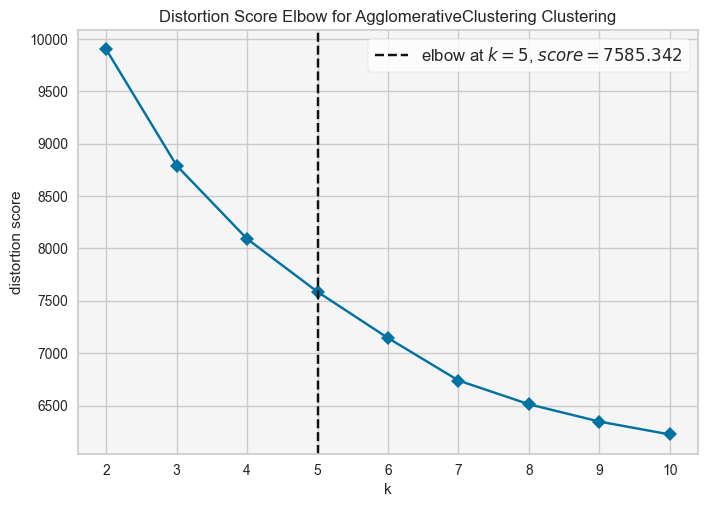

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [70]:
print('Elbow Method to determine the number of clusters to be formed for Agglomerative Clustering:')
Elbow_M = KElbowVisualizer(
    AgglomerativeClustering(),
    k=10,
    locate_elbow=True,
    timings=False
)

# Set a different background color (e.g., light gray)
Elbow_M.ax.set_facecolor("#F5F5F5")

Elbow_M.fit(X_train)
Elbow_M.show()


Elbow Method to determine the number of clusters to be formed for KMeans Clustering:


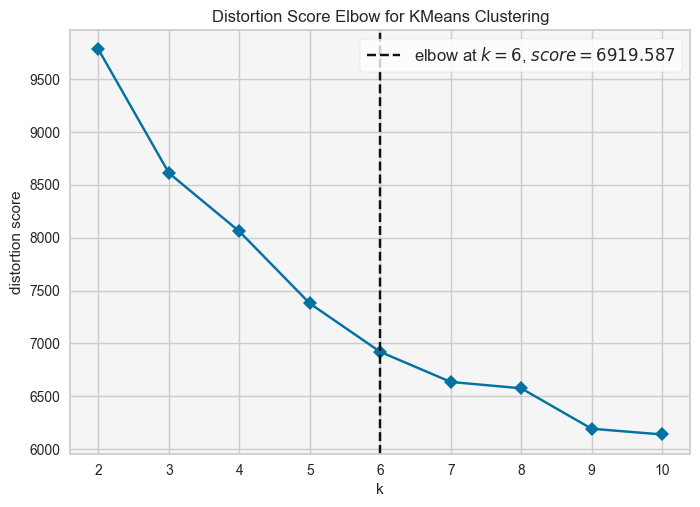

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [71]:
print('Elbow Method to determine the number of clusters to be formed for KMeans Clustering:')
Elbow_M = KElbowVisualizer(
    KMeans(n_init='auto'),
    locate_elbow=True,
    timings=False,
)

# Set a different background color (e.g., light gray)
Elbow_M.ax.set_facecolor("#F5F5F5")

Elbow_M.fit(X_train)
Elbow_M.show()


Pretty decent distortion score for both clustering techniques. Try with PCA dimensionality reduced matrix, if there is >10% improvement, proceed henceforth with PCA-ed matrix.

### Dimensionality Reduction -- Principal Component Analysis

In [74]:
# Perform PCA with 10 components on the standard scaled dataset
pca = PCA(n_components=10, random_state=0)
pca.fit(X_train)

# Create a DataFrame to store the PCA results
PCA_ds = pd.DataFrame(pca.transform(X_train), 
                      columns=["col1", "col2", "col3","col4","col5",'col6','col7','col8','col9','col10'])

# Display summary statistics of the PCA results
PCA_summary = PCA_ds.describe().T
print(PCA_summary)

        count          mean       std       min       25%       50%       75%  \
col1   4328.0 -8.290760e-17  0.787818 -1.497156 -0.598288 -0.089589  0.503835   
col2   4328.0  9.850408e-17  0.637409 -1.230519 -0.386170 -0.151771  0.278778   
col3   4328.0 -6.731112e-17  0.418394 -0.681884 -0.382649 -0.071130  0.348323   
col4   4328.0 -9.439974e-18  0.394497 -1.142873 -0.249626  0.015313  0.229355   
col5   4328.0 -1.518605e-17  0.336975 -1.155240 -0.226129 -0.002697  0.221189   
col6   4328.0  1.785386e-17  0.315240 -0.945456 -0.136269 -0.006590  0.148046   
col7   4328.0 -6.156505e-18  0.305816 -0.850240 -0.228428 -0.001687  0.231127   
col8   4328.0  6.115461e-17  0.296789 -0.825797 -0.138542 -0.035139  0.134207   
col9   4328.0 -2.236863e-17  0.281372 -0.789440 -0.188072 -0.025761  0.128647   
col10  4328.0  6.074418e-17  0.265482 -0.886649 -0.178958 -0.008036  0.173471   

            max  
col1   2.599006  
col2   2.268158  
col3   1.653920  
col4   1.695292  
col5   1.191522  


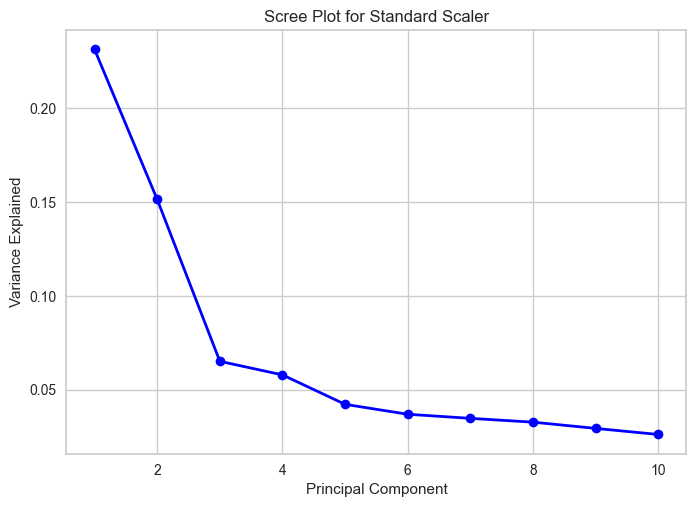

In [75]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot for Standard Scaler')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Ideal PC = 3 for minmax() scaled auto FE

In [76]:
# Perform PCA with 2 components on the standard scaled dataset
pca = PCA(n_components=3, random_state=0)
pca.fit(X_train)

# Create a DataFrame to store the PCA results
PCA_ds = pd.DataFrame(pca.transform(X_train), 
                      columns=["col1", "col2", "col3"])

# Display summary statistics of the PCA results
PCA_summary = PCA_ds.describe().T
print(PCA_summary)

       count          mean       std       min       25%       50%       75%  \
col1  4328.0  6.649025e-17  0.787818 -1.497156 -0.598288 -0.089589  0.503835   
col2  4328.0 -2.790949e-17  0.637409 -1.230519 -0.386170 -0.151771  0.278778   
col3  4328.0 -2.134255e-17  0.418394 -0.681884 -0.382649 -0.071130  0.348323   

           max  
col1  2.599006  
col2  2.268158  
col3  1.653920  


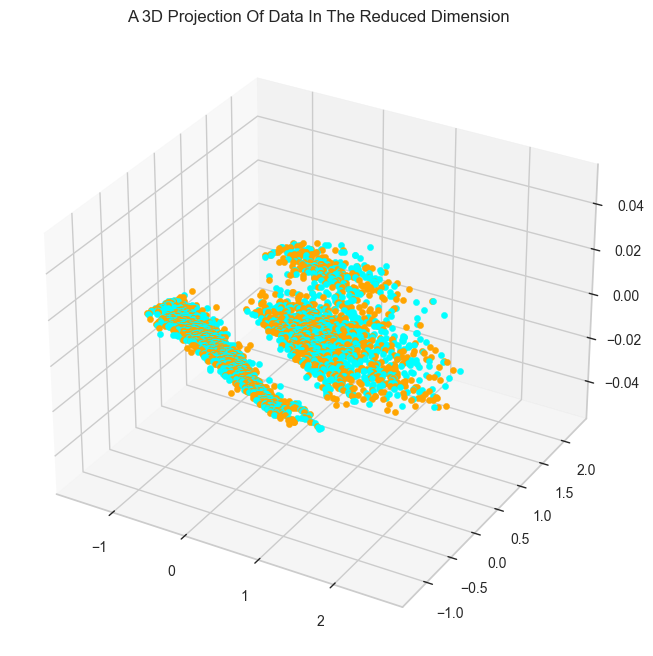

In [78]:
# Extract the PCA components
x = PCA_ds["col1"]
y = PCA_ds["col2"]

# Define colors for the scatter plot
colors = ["orange", "cyan"]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot with bright colors
for i in range(len(x)):
    ax.scatter(x[i], y[i], c=colors[i % len(colors)], marker="o")

# Set the title
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")

# Show the plot
plt.show()

Elbow Method to determine the number of clusters to be formed with Agglomerative CLustering and PCA:


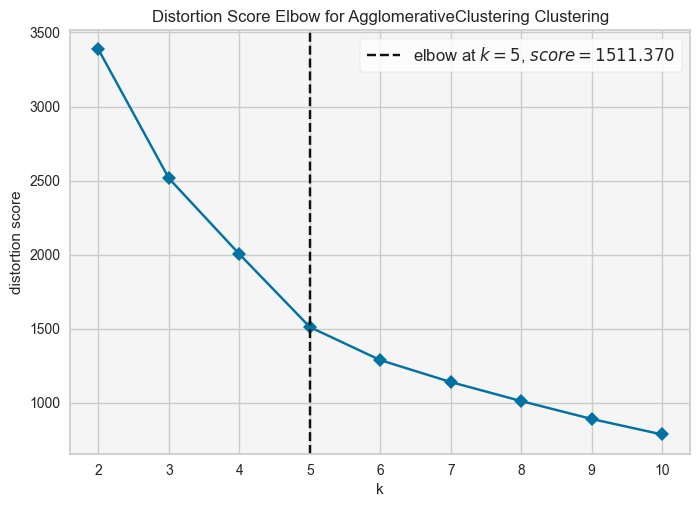

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [79]:
print('Elbow Method to determine the number of clusters to be formed with Agglomerative CLustering and PCA:')
Elbow_M = KElbowVisualizer(
    AgglomerativeClustering(),
    k=10,
    locate_elbow=True,
    timings=False
)

# Set a different background color (e.g., light gray)
Elbow_M.ax.set_facecolor("#F5F5F5")

Elbow_M.fit(PCA_ds)
Elbow_M.show()

Elbow Method to determine the number of clusters to be formed for KMeans Clustering:


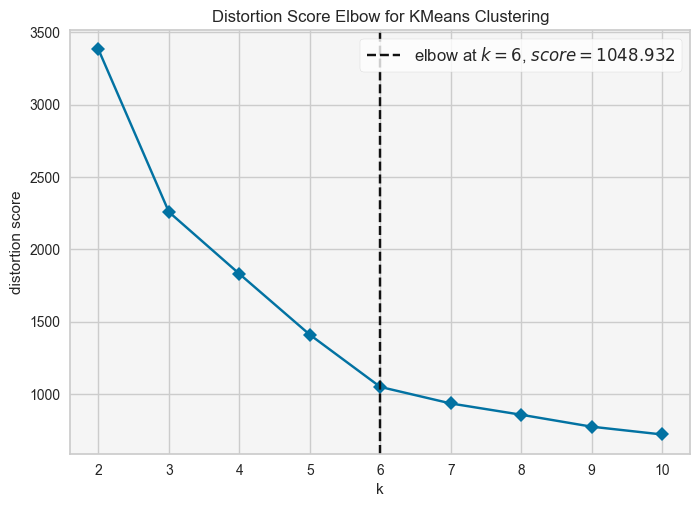

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [80]:
print('Elbow Method to determine the number of clusters to be formed for KMeans Clustering:')
Elbow_M = KElbowVisualizer(
    KMeans(n_init='auto'),
    locate_elbow=True,
    timings=False,
)

# Set a different background color (e.g., light gray)
Elbow_M.ax.set_facecolor("#F5F5F5")

Elbow_M.fit(PCA_ds)
Elbow_M.show()


Significant improvment in performance. Hence, fit to continue with PCA processed dataset with 5 and 6 clusters for both Agglomerative and kmeans clustering respectively.

#### Agglomerative Clustering with 5 clusters

In [81]:
# Initialize the Agglomerative Clustering model with 5 clusters
AC = AgglomerativeClustering(n_clusters=5)

# Fit the model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)

# Add the cluster labels to the PCA DataFrame
PCA_ds["Clusters"] = yhat_AC

# Add the Clusters feature to the original DataFrame
X_train["Clusters"] = yhat_AC

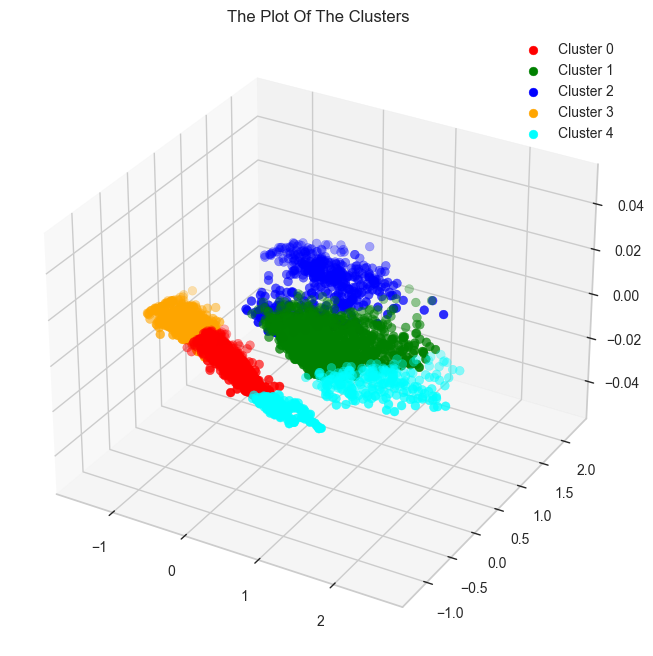

In [82]:
# Extract the PCA components
x = PCA_ds["col1"]
y = PCA_ds["col2"]
z = PCA_ds["col3"]

# Define colors for the clusters
colors = ["red", "green", "blue", "orange", "cyan"]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d', label="bla")

# Scatter plot with cluster-specific colors
for cluster_id in range(len(colors)):
    cluster_data = PCA_ds[PCA_ds["Clusters"] == cluster_id]
    ax.scatter(
        cluster_data["col1"],
        cluster_data["col2"],
        s=40,
        c=colors[cluster_id],
        marker='o',
        label=f'Cluster {cluster_id}'
    )

# Set the title
ax.set_title("The Plot Of The Clusters")

# Add a legend
ax.legend()

# Show the plot
plt.show()


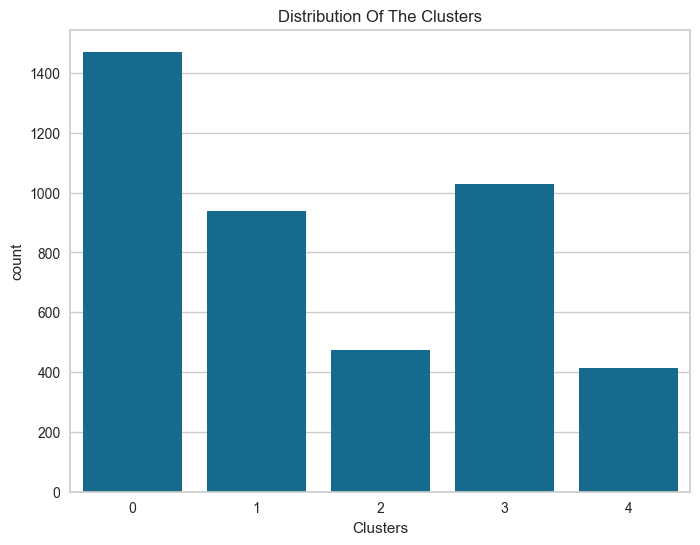

In [83]:
# Create a countplot of the cluster distribution
plt.figure(figsize=(8, 6))
countplot = sns.countplot(x=X_train["Clusters"])

# Set the title
countplot.set_title("Distribution Of The Clusters")

# Show the plot
plt.show()

In [84]:
X_train.groupby(['Clusters', 'PotentialFraud']).count()

COUNT(X)  MAX(X.AdmitForDays)  MAX(X.Age)  \
Clusters PotentialFraud                                              
0        0                   1458                 1458        1458   
         1                     13                   13          13   
1        0                    763                  763         763   
         1                    175                  175         175   
2        0                    422                  422         422   
         1                     53                   53          53   
3        0                   1028                 1028        1028   
         1                      2                    2           2   
4        0                    249                  249         249   
         1                    165                  165         165   

                         MAX(X.ClaimProcessedForDays)  \
Clusters PotentialFraud                                 
0        0                                       1458   
         1                                         13   
1        0                                        763   
         1                                        175   
2        0                                        422   
         1                                         53   
3        0                                       1028   
         1                                          2   
4        0                                        249   
         1                                        165   

                         MAX(X.DeductibleAmtPaid)  \
Clusters PotentialFraud                             
0        0                                   1458   
         1                                     13   
1        0                                    763   
         1                                    175   
2        0                                    422   
         1                                     53   
3        0                                   1028   
         1                                      2   
4        0                                    249   
         1                                    165   

                         MAX(X.IPAnnualDeductibleAmt)  \
Clusters PotentialFraud                                 
0        0                                       1458   
         1                                         13   
1        0                                        763   
         1                                        175   
2        0                                        422   
         1                                         53   
3        0                                       1028   
         1                                          2   
4        0                                        249   
         1                                        165   

                         MAX(X.IPAnnualReimbursementAmt)  \
Clusters PotentialFraud                                    
0        0                                          1458   
         1                                            13   
1        0                                           763   
         1                                           175   
2        0                                           422   
         1                                            53   
3        0                                          1028   
         1                                             2   
4        0                                           249   
         1                                           165   

                         MAX(X.InscClaimAmtReimbursed)  \
Clusters PotentialFraud                                  
0        0                                        1458   
         1                                          13   
1        0                                         763   
         1                                         175   
2        0                                         422   
         1                                        

From the distribution of cluster 3 has a greater proportion and distribution of non-frauds. This means that observations without characteristics similar to cluster 3 (and closer to Cluster 4 with the highest positive fraud proportion) can be considered suspicious.

#### KMeans Clustering with 6 clusters

In [86]:
# Initialize the KMeans Clustering model with 6 clusters
KM = KMeans(n_clusters=6, n_init='auto')

# Fit the model and predict clusters
yhat_KM = KM.fit_predict(PCA_ds)

# Add the cluster labels to the PCA DataFrame
PCA_ds["Clusters"] = yhat_KM

# Add the Clusters feature to the original DataFrame
X_train["Clusters"] = yhat_KM

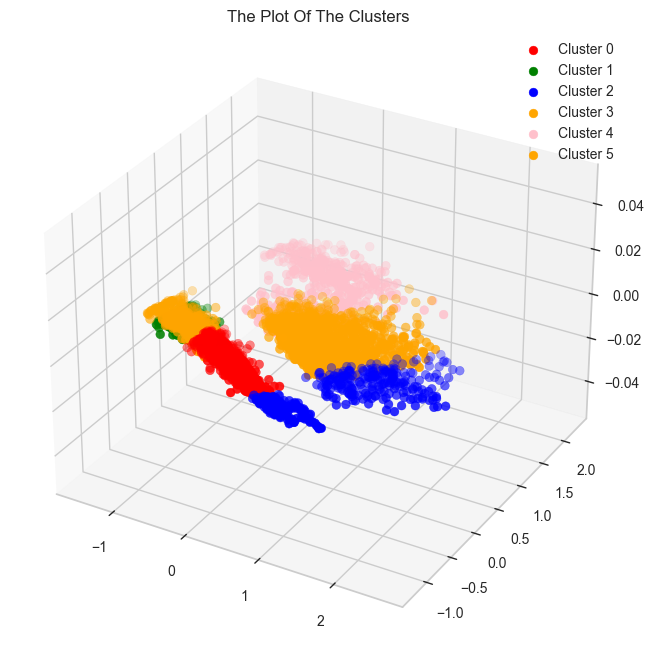

In [87]:
# Extract the PCA components
x = PCA_ds["col1"]
y = PCA_ds["col2"]
z = PCA_ds["col3"]

# Define colors for the clusters
colors = ["red", "green", "blue", "orange", "pink", "orange"]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d', label="bla")

# Scatter plot with cluster-specific colors
for cluster_id in range(len(colors)):
    cluster_data = PCA_ds[PCA_ds["Clusters"] == cluster_id]
    ax.scatter(
        cluster_data["col1"],
        cluster_data["col2"],
        s=40,
        c=colors[cluster_id],
        marker='o',
        label=f'Cluster {cluster_id}'
    )

# Set the title
ax.set_title("The Plot Of The Clusters")

# Add a legend
ax.legend()

# Show the plot
plt.show()


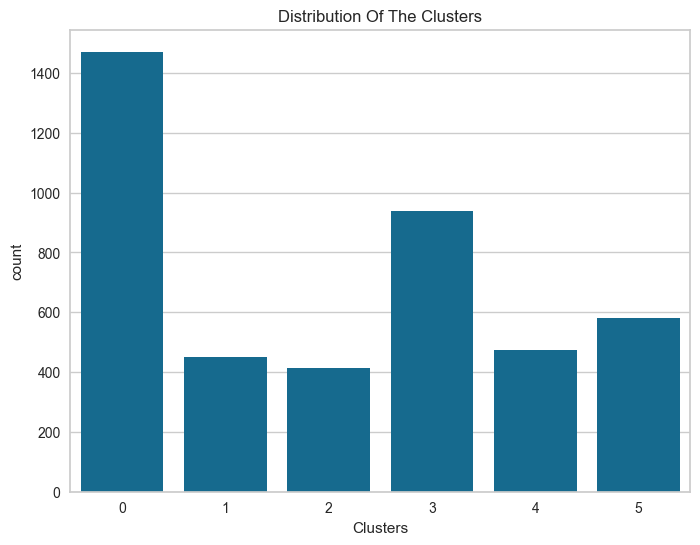

In [88]:
# Create a countplot of the cluster distribution
plt.figure(figsize=(8, 6))
countplot = sns.countplot(x=X_train["Clusters"])

# Set the title
countplot.set_title("Distribution Of The Clusters")

# Show the plot
plt.show()

In [89]:
X_train.groupby(['Clusters', 'PotentialFraud']).count()

COUNT(X)  MAX(X.AdmitForDays)  MAX(X.Age)  \
Clusters PotentialFraud                                              
0        0                   1458                 1458        1458   
         1                     13                   13          13   
1        0                    449                  449         449   
2        0                    249                  249         249   
         1                    165                  165         165   
3        0                    764                  764         764   
         1                    175                  175         175   
4        0                    421                  421         421   
         1                     53                   53          53   
5        0                    579                  579         579   
         1                      2                    2           2   

                         MAX(X.ClaimProcessedForDays)  \
Clusters PotentialFraud                                 
0        0                                       1458   
         1                                         13   
1        0                                        449   
2        0                                        249   
         1                                        165   
3        0                                        764   
         1                                        175   
4        0                                        421   
         1                                         53   
5        0                                        579   
         1                                          2   

                         MAX(X.DeductibleAmtPaid)  \
Clusters PotentialFraud                             
0        0                                   1458   
         1                                     13   
1        0                                    449   
2        0                                    249   
         1                                    165   
3        0                                    764   
         1                                    175   
4        0                                    421   
         1                                     53   
5        0                                    579   
         1                                      2   

                         MAX(X.IPAnnualDeductibleAmt)  \
Clusters PotentialFraud                                 
0        0                                       1458   
         1                                         13   
1        0                                        449   
2        0                                        249   
         1                                        165   
3        0                                        764   
         1                                        175   
4        0                                        421   
         1                                         53   
5        0                                        579   
         1                                          2   

                         MAX(X.IPAnnualReimbursementAmt)  \
Clusters PotentialFraud                                    
0        0                                          1458   
         1                                            13   
1        0                                           449   
2        0                                           249   
         1                                           165   
3        0                                           764   
         1                                           175   
4        0                                           421   
         1                                            53   
5        0                                           579   
         1                                             2   

                         MAX(X.InscClaimAmtReimbursed)  \
Clusters PotentialFraud                                  
0        0                                 

Cluster 2 has the highest number of frauds:non frauds ratio -- perhaps observations close to cluster 2 might be fradulent.

In [90]:
# to explain the characteristics of the clusters, get columns with top 5 variance
column_variances = X_train.var()
sorted_columns = column_variances.sort_values(ascending=False)
top_10_columns = sorted_columns.head(10)
cols = top_10_columns.index.tolist()
cols.append('PotentialFraud')

In [91]:
x= X_train.groupby('Clusters')[cols].sum()
count = X_train.groupby('Clusters')['Clusters'].count()
x = x.div(count, axis=0) 
x

,Clusters,MAX(X.DeductibleAmtPaid),MODE(X.Gender),MIN(X.NoOfMonths_PartACov),MIN(X.NoOfMonths_PartBCov),NUM_UNIQUE(X.Race),MODE(X.ClmDiagnosisCode_1_ce),MAX(X.AdmitForDays),MODE(X.State),PotentialFraud,PotentialFraud
Clusters,,,,,,,,,,,
0,0.0,0.070362,0.881033,0.762463,0.778042,0.588035,0.207572,0.000850,0.480625,0.008838,0.008838
1,1.0,0.010573,1.000000,1.000000,0.999258,0.139569,0.020885,0.001114,0.490902,0.000000,0.000000
2,2.0,0.637233,0.997585,0.011473,0.091787,0.904992,0.599323,0.376812,0.441163,0.398551,0.398551
3,3.0,1.000000,0.931842,0.756922,0.751065,0.671636,0.174651,0.468140,0.445154,0.186368,0.186368
4,4.0,1.000000,0.417722,0.949719,0.950246,0.307314,0.040422,0.404653,0.509394,0.111814,0.111814
5,5.0,0.022417,0.003442,0.967728,0.950660,0.195640,0.039000,0.000000,0.494820,0.003442,0.003442


As suspected from the EDA, DeductibleAmtPaid contributed the most to clustering distribution, accounting to Fraudulent transactions having high DeductibleAmtPaid, as seen from Cluster 2,3 and 4.

## 6. Model Building <a class="anchor" id="chapter6"></a>

Now that we have the feature matrices for our providers, we can proceed to build our models. We will be building the following 6 models:
- KNearestNeighbours
- LogisticRegression
- RandomForest
- XGBoost
- Support Vector Machine (SVM)
- Multi-level Perceptron (Neural Network/NN)

This will allow us to analyse a variety of commonly used models and their performance.

### 6.1 Defining Helper Functions <a class="anchor" id="section_6_1"></a>
Here we define some helper functions that can aid us in the model building process and in model evaluating performance.

#### First we define helper functions to evaluate and track model performance.

In [ ]:
# These global variables will be used to consolidate the best model performance across all 6 models.
all_model = []
all_type = []
all_accuracy = []
all_precision = []
all_recall = []
all_F1score = []
all_AUCROC = []

# These variables will be used to consolidate an individual model's performance.
local_model = []
local_type = []
local_accuracy = []
local_precision = []
local_recall = []
local_F1score = []
local_AUCROC = []

In [ ]:
def test_eval(clf_model, X, y, model_name=None, data_type=None, is_svm=False):
    """Carries out prediction using model and features supplied.
    Subsequently, it will output the model's performance results.

    Parameters
    ----------
    clf_model : Predictor
        Classification model used for prediction
    X : Dataframe
        Dataframe containing features to use for prediction
    y : Dataframe
        Dataframe containing labels of the Providers
    model_name : String, optional
        Name of the model used, by default None
    data_type : String, optional
        Type of data that model was trained on, by default None
    is_svm : Boolean, optional
        Boolean of whether the model supplied is a SVM model. 
        Required as it doesn't have its own predict_proba 
        function to aid in calculating auc.

    Returns
    -------
    list
        Returns a list containing the name of the model, the accuracy, 
        precision, recall, f1 and AUC scores of the model after predicting.
    """

    # Predict
    y_pred = clf_model.predict(X)

    # Get scores
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    if is_svm:
        fpr, tpr, _ = roc_curve(y, y_pred)
        auc_score = auc(fpr, tpr)
    else:
        y_prob = clf_model.predict_proba(X)
        auc_score = roc_auc_score(y, y_prob[:, 1])

    # Print in a presentable manner
    print("Confusion Matrix")
    print("=" * 60)
    print(confusion_matrix(y, y_pred), "\n")
    print("Classification Report")
    print("=" * 60)
    print(classification_report(y, y_pred), "\n")
    print("AUC-ROC")
    print("=" * 60)
    print(auc_score)

    local_model.append(model_name)
    local_type.append(data_type)
    local_accuracy.append(accuracy)
    local_precision.append(precision)
    local_recall.append(recall)
    local_F1score.append(f1)
    local_AUCROC.append(auc_score)
    return [model_name, data_type, accuracy, precision, recall, f1, auc_score]

def print_model_comparison(models, types, accuracies, precisions, recalls, f1s, aucs):
    """Prints a comparison of all the models supplied and their performance.

    Parameters
    ----------
    models : list
        List of models
    types : list
        List of the type of data used to train each model
    accuracies : list
        List of accuracy scores for each model's performance
    precisions : list
        List of precision scores for each model's performance
    recalls : list
        List of recall scores for each model's performance
    f1s : list
        List of F1 scores for each model's performance
    aucs : list
        List of AUC scores for each model's performance
    """
    model_comparison = pd.DataFrame(
        {
            'Model': models,
            'Type': types,
            'Accuracy': accuracies,
            'Precision': precisions,
            'Recall': recalls,
            'F1-Score': f1s,
            'ROC-AUC': aucs
        }
    )
    display(model_comparison)

#### Next we define helper functions to carry out feature importance


In [ ]:
def get_top10_features(model, model_name):
    plt.figure(figsize=(6,3))

    feature_importances = model.feature_importances_
    order = np.flip(np.argsort(feature_importances))[0:10]
    plt.barh(range(10),
            feature_importances[order],
            tick_label=model.feature_names_in_[order])
    plt.title(f"Relative Feature Importance for {model_name} Model")
    plt.show()

    top_features = pd.DataFrame()
    top_features['feature'] = model.feature_names_in_
    top_features['importance'] = feature_importances
    top_features.sort_values(by = 'importance', ascending=False, inplace=True)

    top10_features = top_features[:10]
    display(top10_features)
    return list(top10_features.feature)

### 6.2 EDA on Training Data  <a class="anchor" id="section_6_2"></a>
Before training our models, let us examine the distribution of our training data to determine if there is any class imbalancing present.

In [ ]:
# Plot distribution of fraud class in training data.
non_fraud_count, fraud_count = y_train.value_counts()
print(f'Non-fraud Count: {non_fraud_count}, Fraud Count: {fraud_count}')
print(f'Percentage of fraud: {fraud_count / (non_fraud_count + fraud_count)}')
fig, ax = plt.subplots()
fig.suptitle('Distribution of Fraud')
labels = ['0', '1']
counts= [non_fraud_count, fraud_count]
ax.set_ylabel('No. of Providers')
ax.set_xlabel("PotentialFraud")
bars = ax.bar(labels, counts, color = ('red','green'))
plt.show()

```Based on the chart and calculations above, we can see that the training data is imbalanced as the fraud class only accounts for about 9% of the entire training set. As such, we will apply the use of Synthetic Minority Oversampling Technique (SMOTE) to handle the class imbalancing issue. As there is a variant of SMOTE known as SMOTE-NC (SMOTE-Nominal Categorical) which is able to handle categorical features, we will first do a simple check to see which variant of SMOTE to use.```

In [ ]:
[print(i) for i,v in X_train.dtypes.items() if v == 'category']

Based on the result above, there is no categorical features in our training data. As such, we will use SMOTE.

### 6.3 SMOTE <a class="anchor" id="section_6_3"></a>
As mentioned, we will utilise SMOTE on our training data to handle the class imbalancing issue. This is necessary to ensure that we are able to mitigate bias and capture the important features of the minority (fraud) class

In [ ]:
# Convert all cols to float64 to fit into tensor
X_train_float = X_train.astype('float64')

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE(random_state=4012)
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train, y_train = smt.fit_resample(X_train_float, y_train)

counter = Counter(y_train)
print('After',counter)

### 6.4 Logistic Regression <a class="anchor" id="section_6_4"></a>
Now that we have applied SMOTE to our data, we will begin by building a Logistic Regression Model.

In [ ]:
# Init model
model = LogisticRegressionCV(
    cv=10, 
    class_weight='balanced', 
    random_state=4012,
    max_iter=10000,
    solver='saga' 
)
model_name = 'Logistic Regression'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
print('Train Results')
test_eval(model, X_train, y_train, model_name, 'All Features')
print()
# Evaluate on test
print('Test Results')
test_eval(model, X_test, y_test, model_name, 'All Features')

#### Evaluate Model Performance
Next let's take a look at the model's performance

In [ ]:
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

Based on the results, we will append the model at index 1 to our list of best model performance.

*Note: we only have 1 logistic regression model as this model is meant to be our base model.*

In [ ]:
# Get best model
best_model_index = 1
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()

### 6.5 KNearestNeighbours <a class="anchor" id="section_6_5"></a>
Then we build a KNearestNeighbours (KNN) model and evaluate its performance.

In [ ]:
# Init model
model = KNeighborsClassifier(n_neighbors=5)
model_name = 'KNearestNeighbours'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features')
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features')

#### Feature Importance
Next, we select the top 10 features and retrain our model. We will use permutation importance for KNN as it does not have built in feature importance.

In [ ]:
results = permutation_importance(model, X_test, y_test, scoring='accuracy', random_state=4012)

# Map the scores with the feature names and extract top 10
importance_scores = results.importances_mean
feature_importances = dict(zip(X_train.columns, importance_scores))
top_10_features = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)[:10]
print("Top 10 feature importances:", top_10_features)

In [ ]:
top10_features = [feature[0] for feature in top_10_features]
X_train_top10 = X_train[top10_features]
X_test_top10 = X_test[top10_features]

In [ ]:
# Init model
model = KNeighborsClassifier(n_neighbors=5)
# Fit
model.fit(X_train_top10, y_train)
# Evaluate on train
test_eval(model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Hyperparameter Tuning

In [ ]:
untuned_model = KNeighborsClassifier()
param_grid = param_grid = {'n_neighbors': range(1, 31)}
model_name = 'KNearestNeighbours Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
# Print best set of parameters
tuned_model.fit(X_train_top10, y_train)
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on Train
test_eval(tuned_model, X_train_top10, y_train, model_name, 'Train Top 10 Features')
# Evaluate on test
test_eval(tuned_model, X_test_top10, y_test, model_name, 'Test Top 10 Features')

In [ ]:
# Print model comparison
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

Based on the results, the best model with highest AUC score is the model trained on all the features at index 1.

In [ ]:
# Get best model
best_model_index = 1
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()

### 6.6 Support Vector Machine <a class="anchor" id="section_6_6"></a>
Next we build our SVM model. We will build 3, 1 using the linear kernel, 1 using polynomial kernel and 1 using the radial kernel.

In [ ]:
# Init SVM on linear kernel
model = LinearSVC(random_state=4012)
model_name = 'Linear SVM'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features', True)

In [ ]:
# Init SVM on polynomial kernel
model = SVC(kernel='poly', random_state=4012)
model_name = 'Polynomial SVM'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features', True)

In [ ]:
# Init SVM on radial kernel
model = SVC(kernel='rbf', random_state=4012)
model_name = 'Radial SVM'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features', True)

#### Hyperparameter Tuning

In [ ]:
# Init untuned model and param_grid
untuned_model = LinearSVC(random_state=4012)
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [1000, 10000],
    'tol': [1e-3, 1e-4]
}

model_name = 'Linear SVM Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(tuned_model, X_test, y_test, model_name, 'Test All features', True)

In [ ]:
# Init untuned model and param_grid
untuned_model = SVC(kernel='poly', random_state=4012)
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [1000, 10000],
    'tol': [1e-3, 1e-4]
}

model_name = 'Poly SVM Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(tuned_model, X_test, y_test, model_name, 'Test All features', True)

In [ ]:
# Init untuned model and param_grid
untuned_model = SVC(kernel='rbf', random_state=4012)
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [1000, 10000],
    'tol': [1e-3, 1e-4]
}

model_name = 'Radial SVM Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(tuned_model, X_test, y_test, model_name, 'Test All features', True)

#### Evaluate SVM models performance
Now we evaluate the performance of all 3 SVM models and determine the best one to carry out hyperparameter tuning on.

In [ ]:
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

From the results shown, the best performing model with highest AUC score is the tuned linear SVM model (index 7).

In [ ]:
# Get best model
best_model_index = 7
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()


### 6.7 Random Forest <a class="anchor" id="section_6_7"></a>
Next we train a Random Forest model.

In [ ]:
model = RandomForestClassifier(random_state=4012)
model_name = 'Random Forest'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features')
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features')

#### Feature Importance
Next we utilise Random Forest's built in feature importance to find the top 10 features, and retrain our model on those features only.

In [ ]:
# Get top 10
top10_features = get_top10_features(model, model_name)
# Create top10 train and test
X_train_top10, X_test_top10 = X_train[top10_features], X_test[top10_features]

In [ ]:
# Retrain model
model = RandomForestClassifier(random_state=4012)
# Fit
model.fit(X_train_top10, y_train)
# Evaluate on train
test_eval(model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Hyperparameter Tuning

In [ ]:
# Init untuned model and param_grid
untuned_model = RandomForestClassifier(random_state=4012)
param_grid = {
  'n_estimators': [100, 200],
  'criterion': ['gini', 'entropy'],
  'max_depth': [10, 20, 30, None],
  'min_samples_split': [2, 10, 20],
  'min_samples_leaf': [1, 2, 4, 8],
  'bootstrap': [True, False]
}
model_name = 'Random Forest Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train_top10, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(tuned_model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Evaluate Random Forest Models Performance

In [ ]:
# Print model comparison
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

Based on the results above, the best random forest model with highest AUC score is the random forest trained on all features (index 1). 

In [ ]:
# Get best model
best_model_index = 1
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()

### 6.8 Multi-Layer Perceptron <a class="anchor" id="section_6_8"></a>
Next we will train a multi-layer perceptron model.

In [ ]:
LeakyReLU = LeakyReLU(alpha=0.1)

In [ ]:
# Create function to find the best model based on Area Under Curve
def nn_bayesopt(neurons, activation, optimizer, learning_rate, batch_size, epochs, layers1, layers2, dropout, dropout_rate):
    
    #some common optimizers and activation function
    optimizerL = ['Adam', 'RMSprop']
    optimizerD= {'Adam':Adam(learning_rate==learning_rate), 'RMSprop':RMSprop(learning_rate=learning_rate)}
    activationL = ['relu', 'sigmoid', 'tanh', 'elu', LeakyReLU]
    
    #choosing which optimizer to use based on numbers
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    
    #relevant hyperparameters
    batch_size = round(batch_size)
    epochs = round(epochs)
    
    #structure of nn
    neurons = round(neurons)
    layers1 = round(layers1)
    layers2 = round(layers2)
    
    #nn using keras
    nn = Sequential()
    #input layer + first hidden layer (29 features)
    nn.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
    for i in range(layers1):
        nn.add(Dense(neurons, activation=activation))
    if dropout > 0.5:
        nn.add(Dropout(dropout_rate, seed=42))
    for i in range(layers2):
        nn.add(Dense(neurons, activation=activation))
    #output layer with 1 output
    nn.add(Dense(1, activation='sigmoid'))

    nn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[AUC()])

    es = EarlyStopping(monitor='val_loss', verbose=0, patience=20)
    
    nn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])
    
    # AUC score for binary classification determining the best model
    score, auc = nn.evaluate(X_test, y_test, verbose=0)

    return auc

In [ ]:
params_nn = {
    'neurons': (1, 35),
    'activation':(0, 4),
    'optimizer':(0,1),
    'learning_rate':(0.001, 0.2),
    'batch_size':(128, 1500),
    'epochs':(30, 150),
    'layers1':(0,5),
    'layers2':(0,2),
    'dropout':(0,1),
    'dropout_rate':(0,0.2),
}

# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_bayesopt, params_nn, random_state=42)
nn_bo.maximize(init_points=20, n_iter=10)

In [ ]:
#get best params
params_nn = nn_bo.max['params']

learning_rate = params_nn['learning_rate']
activationL = ['relu', 'sigmoid', 'tanh', 'elu', LeakyReLU]
params_nn['activation'] = activationL[round(params_nn['activation'])]

params_nn['batch_size'] = round(params_nn['batch_size'])
params_nn['epochs'] = round(params_nn['epochs'])

params_nn['layers1'] = round(params_nn['layers1'])
params_nn['layers2'] = round(params_nn['layers2'])
params_nn['neurons'] = round(params_nn['neurons'])

optimizerL = ['Adam', 'RMSprop']
optimizerD= {'Adam':Adam(learning_rate==learning_rate), 'RMSprop':RMSprop(learning_rate=learning_rate)}
params_nn['optimizer'] = optimizerD[optimizerL[round(params_nn['optimizer'])]]

print(params_nn)

In [ ]:
#hyperparameters
best_params = params_nn
activation = best_params["activation"]
batch_size =  best_params["batch_size"]
dropout = best_params["dropout"]

dropout_rate = best_params["dropout_rate"]
epochs = best_params["epochs"]
layers1 = best_params["layers1"]
layers2 = best_params["layers2"]
neurons = best_params["neurons"]
optimizer = best_params["optimizer"]

In [ ]:
X_train_nn = X_train.astype('float64')
y_train_nn = y_train.astype('float64')
X_test_nn = X_test.astype('float64')
y_test_nn = y_test.astype('float64')
# hyperparameter and parameter tuned model
nn = Sequential()
#input layer + first hidden layer
nn.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
#hidden layer
for i in range(layers1):
    nn.add(Dense(neurons, activation=activation))
if dropout > 0.5:
    nn.add(Dropout(dropout_rate, seed=42))
for i in range(layers2):
    nn.add(Dense(neurons, activation=activation))
#output layer with 2 outputs
nn.add(Dense(1, activation='sigmoid'))
nn.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[Precision(), Recall(), 'accuracy', F1Score()])
es = EarlyStopping(monitor='val_loss', verbose=0, patience=20)
nn.fit(X_train_nn, y_train_nn, validation_data=(X_test_nn, y_test_nn), epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])   

In [ ]:
# Define custom evaluator for NN
def evaluate_model(model_name, train_model, x_eval_df, y_eval_df, data_type):
   # Predict
   y_pred = train_model.predict(x_eval_df)
   y_pred = np.where(y_pred > 0.5, 1, 0)
   # Get scores
   loss, precision, recall, accuracy, f1  = train_model.evaluate(x_eval_df, y_eval_df, verbose=0)
   fpr, tpr, _ = roc_curve(y_eval_df, y_pred)
   auc_score = auc(fpr, tpr)


   # Print in a presentable manner
   print("Confusion Matrix")
   print("=" * 60)
   print(confusion_matrix(y_eval_df, y_pred), "\n")
   print("Classification Report")
   print("=" * 60)
   print(classification_report(y_eval_df, y_pred), "\n")
   print("AUC-ROC")
   print("=" * 60)
   print(auc_score)

   local_model.append(model_name)
   local_type.append(data_type)
   local_accuracy.append(accuracy)
   local_precision.append(precision)
   local_recall.append(recall)
   local_F1score.append(f1[0])
   local_AUCROC.append(auc_score)
   return [model_name, data_type, accuracy, precision, recall, f1, auc_score]

In [ ]:
evaluate_model('Multilayer Perceptron', nn, X_train_nn, y_train_nn, 'Train All features')
evaluate_model('Multilayer Perceptron', nn, X_test_nn, y_test_nn, 'Test All features')

In [ ]:
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

In [ ]:
# Get best model
best_model_index = 1
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()

### 6.9 XGBoost <a class="anchor" id="section_6_9"></a>
Finally, we train the XGBoost model.

In [ ]:
model = XGBClassifier(random_state = 4012)
model_name = 'XGBoost'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features')
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features')

#### Feature Importance
Next we utilise XGBoost's built in feature importance to find the top 10 features, and retrain our model on those features only.

In [ ]:
# Get top 10
top10_features = get_top10_features(model, model_name)
# Create top10 train and test
X_train_top10, X_test_top10 = X_train[top10_features], X_test[top10_features]

In [ ]:
model = XGBClassifier(random_state = 4012)
# Fit
model.fit(X_train_top10, y_train)
# Evaluate on train
test_eval(model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Hyperparameter Tuning

In [ ]:
untuned_model = XGBClassifier(random_state = 4012)
param_grid = {
    'objective': ['reg:squarederror'],
    'eta' : [i / 20 for i in range(1, 21)],   # learning rate at increments of 0.05
    'gamma': [0.1, 0.5, 1.0],    # minimum loss reduction
    'lambda' : [0.1, 0.5, 1.0],  # L2 regularization term
    'alpha' : [0.1, 0.5, 1.0],   # L1 regularization term,
}
model_name = 'XGBoost Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train_top10, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(tuned_model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Evaluate XGBoost Model Performance

In [ ]:
# Print model comparison
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

Based on the results above, the best performing model with highest AUC is the model trained on all the features (index 1). However, we can also observe that it has a lower recall score as compared to the tuned model that is trained on the top 10 features only (index 5). In the context of fraud detection, higher recall is more important as a false negative can mean that a fraudulent provider is allowed to slip under the radar.

In [ ]:
best_model_index = 5
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()


### 6.10 Overall Model Evaluation <a class="anchor" id="section_6_10"></a>
Now let us take a look at the performance of the best model variant from each type of model that we have chosen.

In [ ]:
print_model_comparison(
    models=all_model,
    types=all_type,
    accuracies=all_accuracy,
    precisions=all_precision,
    recalls=all_recall,
    f1s=all_F1score,
    aucs=all_AUCROC,
)

Based on the results above, the top 3 models by AUC score is the Random Forest model, followed by the Logistic Regression model and lastly the XGBoost model. On the other hand, the top 3 models by recall score is KNearestNeighbours, LinearSVM and the logistic regression model.

It is interesting to note that the best model variants for all the models trained on different types of data performed best when trained on all the features, with the exception of the XGBoost model.

However, had we chosen the XGBoost model with the best AUC score, it would've ranked as the best performing model by AUC score.

## 7. Advanced Models <a class="anchor" id="chapter7"></a>
Moving on, we have also attempted to create word embeddings from the code columns in our data. The process to create those embeddings are located in the `DiagnosisCodes.ipynb` notebook. In addition, we have also explored graph based methods in hopes of deriving meaningful features that can aid us in detecting fraudulent providers. This process has been documented in our `graph structures.ipynb` notebook. 

Here, we will directly import the results and determine whether the inclusion of these features can help us to generate better performance on our models.

In [ ]:
graph_df = pd.read_csv("provider_graph_features.csv")
embed_train = pd.read_pickle('data/embed_df_train.pkl').reset_index().rename({'index': 'Provider'}, axis=1)
embed_val = pd.read_pickle('data/embed_df_val.pkl').reset_index().rename({'index': 'Provider'}, axis=1)

In [ ]:
# Reload base data
X = feature_matrix_providers.astype('float64')
y = feature_matrix_providers.PotentialFraud
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4012)

In [ ]:
# Merging graph dfs 
graph = graph_df.drop(['PotentialFraud'], axis=1)

x_train_joined = pd.merge(X_train, graph, on='Provider', how='left')
x_test_fe_joined = pd.merge(X_test, graph, on='Provider', how='left')

# Merging embedding dfs 
x_train_joined = pd.merge(x_train_joined, embed_train, on='Provider', how='left')
x_test_fe_joined = pd.merge(x_test_fe_joined, embed_val, on='Provider', how='left')

# Drop target columns & impute NaNs with 0
x_train_full = x_train_joined.drop(['PotentialFraud', 'Provider'], axis=1)
x_test_full = x_test_fe_joined.drop(['PotentialFraud', 'Provider'], axis=1)

x_train_full.fillna(0, inplace=True)
x_test_full.fillna(0, inplace=True)

In [ ]:
x_train_full.columns = x_train_full.columns.astype('str')
x_test_full.columns = x_test_full.columns.astype('str')
# Re scale the data
minmaxScaler = MinMaxScaler()

# Fit the scaler on train data
cols_to_scale = x_train_full.columns.difference(['ClaimID', 'Provider'])
minmaxScaler.fit(x_train_full[cols_to_scale])

# Transform train and test data
x_train_full[cols_to_scale] = minmaxScaler.transform(x_train_full[cols_to_scale])
x_test_full[cols_to_scale] = minmaxScaler.transform(x_test_full[cols_to_scale])

In [ ]:
# Re SMOTE the data

# Convert all cols to float64 to fit into tensor
X_train_float = x_train_full.astype('float64')

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE(random_state=4012)
#X_train, y_train = smt.fit_resample(X_train, y_train)
x_train_full, y_train = smt.fit_resample(X_train_float, y_train)

counter = Counter(y_train)
print('After',counter)

## Everything here until the next marker is to evaluate for Theja's embeddings only

In [ ]:
X_train = x_train_full.drop(list(graph_df.columns[2:].astype('str')), axis = 1)
X_test = x_test_full.drop(list(graph_df.columns[2:].astype('str')), axis = 1)

### 6.4 Logistic Regression <a class="anchor" id="section_6_4"></a>
Now that we have applied SMOTE to our data, we will begin by building a Logistic Regression Model.

In [ ]:
# Init model
model = LogisticRegressionCV(
    cv=10, 
    class_weight='balanced', 
    random_state=4012,
    max_iter=10000,
    solver='saga' 
)
model_name = 'Logistic Regression'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
print('Train Results')
test_eval(model, X_train, y_train, model_name, 'All Features')
print()
# Evaluate on test
print('Test Results')
test_eval(model, X_test, y_test, model_name, 'All Features')

#### Evaluate Model Performance
Next let's take a look at the model's performance

In [ ]:
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

Based on the results, we will append the model at index 1 to our list of best model performance.

*Note: we only have 1 logistic regression model as this model is meant to be our base model.*

In [ ]:
# Get best model
best_model_index = 1
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()

### 6.5 KNearestNeighbours <a class="anchor" id="section_6_5"></a>
Then we build a KNearestNeighbours (KNN) model and evaluate its performance.

In [ ]:
# Init model
model = KNeighborsClassifier(n_neighbors=5)
model_name = 'KNearestNeighbours'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features')
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features')

#### Feature Importance
Next, we select the top 10 features and retrain our model. We will use permutation importance for KNN as it does not have built in feature importance.

In [ ]:
results = permutation_importance(model, X_test, y_test, scoring='accuracy', random_state=4012)

# Map the scores with the feature names and extract top 10
importance_scores = results.importances_mean
feature_importances = dict(zip(X_train.columns, importance_scores))
top_10_features = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)[:10]
print("Top 10 feature importances:", top_10_features)

In [ ]:
top10_features = [feature[0] for feature in top_10_features]
X_train_top10 = X_train[top10_features]
X_test_top10 = X_test[top10_features]

In [ ]:
# Init model
model = KNeighborsClassifier(n_neighbors=5)
# Fit
model.fit(X_train_top10, y_train)
# Evaluate on train
test_eval(model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Hyperparameter Tuning

In [ ]:
untuned_model = KNeighborsClassifier()
param_grid = param_grid = {'n_neighbors': range(1, 31)}
model_name = 'KNearestNeighbours Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
# Print best set of parameters
tuned_model.fit(X_train_top10, y_train)
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on Train
test_eval(tuned_model, X_train_top10, y_train, model_name, 'Train Top 10 Features')
# Evaluate on test
test_eval(tuned_model, X_test_top10, y_test, model_name, 'Test Top 10 Features')

In [ ]:
# Print model comparison
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

Based on the results, the best model with highest AUC score is the model trained on all the features at index 1.

In [ ]:
# Get best model
best_model_index = 1
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()

### 6.6 Support Vector Machine <a class="anchor" id="section_6_6"></a>
Next we build our SVM model. We will build 3, 1 using the linear kernel, 1 using polynomial kernel and 1 using the radial kernel.

In [ ]:
# Init SVM on linear kernel
model = LinearSVC(random_state=4012)
model_name = 'Linear SVM'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features', True)

In [ ]:
# Init SVM on polynomial kernel
model = SVC(kernel='poly', random_state=4012)
model_name = 'Polynomial SVM'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features', True)

In [ ]:
# Init SVM on radial kernel
model = SVC(kernel='rbf', random_state=4012)
model_name = 'Radial SVM'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features', True)

#### Hyperparameter Tuning

In [ ]:
# Init untuned model and param_grid
untuned_model = LinearSVC(random_state=4012)
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [1000, 10000],
    'tol': [1e-3, 1e-4]
}

model_name = 'Linear SVM Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(tuned_model, X_test, y_test, model_name, 'Test All features', True)

In [ ]:
# Init untuned model and param_grid
untuned_model = SVC(kernel='poly', random_state=4012)
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [1000, 10000],
    'tol': [1e-3, 1e-4]
}

model_name = 'Poly SVM Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(tuned_model, X_test, y_test, model_name, 'Test All features', True)

In [ ]:
# Init untuned model and param_grid
untuned_model = SVC(kernel='rbf', random_state=4012)
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [1000, 10000],
    'tol': [1e-3, 1e-4]
}

model_name = 'Radial SVM Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(tuned_model, X_test, y_test, model_name, 'Test All features', True)

#### Evaluate SVM models performance
Now we evaluate the performance of all 3 SVM models and determine the best one to carry out hyperparameter tuning on.

In [ ]:
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

From the results shown, the best performing model with highest AUC score is the tuned linear SVM model (index 7).

In [ ]:
# Get best model
best_model_index = 7
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()


### 6.7 Random Forest <a class="anchor" id="section_6_7"></a>
Next we train a Random Forest model.

In [ ]:
model = RandomForestClassifier(random_state=4012)
model_name = 'Random Forest'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features')
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features')

#### Feature Importance
Next we utilise Random Forest's built in feature importance to find the top 10 features, and retrain our model on those features only.

In [ ]:
# Get top 10
top10_features = get_top10_features(model, model_name)
# Create top10 train and test
X_train_top10, X_test_top10 = X_train[top10_features], X_test[top10_features]

In [ ]:
# Retrain model
model = RandomForestClassifier(random_state=4012)
# Fit
model.fit(X_train_top10, y_train)
# Evaluate on train
test_eval(model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Hyperparameter Tuning

In [ ]:
# Init untuned model and param_grid
untuned_model = RandomForestClassifier(random_state=4012)
param_grid = {
  'n_estimators': [100, 200],
  'criterion': ['gini', 'entropy'],
  'max_depth': [10, 20, 30, None],
  'min_samples_split': [2, 10, 20],
  'min_samples_leaf': [1, 2, 4, 8],
  'bootstrap': [True, False]
}
model_name = 'Random Forest Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train_top10, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(tuned_model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Evaluate Random Forest Models Performance

In [ ]:
# Print model comparison
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

Based on the results above, the best random forest model with highest AUC score is the random forest trained on all features (index 1). 

In [ ]:
# Get best model
best_model_index = 1
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()

### 6.8 Multi-Layer Perceptron <a class="anchor" id="section_6_8"></a>
Next we will train a multi-layer perceptron model.

In [ ]:
LeakyReLU = LeakyReLU(alpha=0.1)

In [ ]:
# Create function to find the best model based on Area Under Curve
def nn_bayesopt(neurons, activation, optimizer, learning_rate, batch_size, epochs, layers1, layers2, dropout, dropout_rate):
    
    #some common optimizers and activation function
    optimizerL = ['Adam', 'RMSprop']
    optimizerD= {'Adam':Adam(learning_rate==learning_rate), 'RMSprop':RMSprop(learning_rate=learning_rate)}
    activationL = ['relu', 'sigmoid', 'tanh', 'elu', LeakyReLU]
    
    #choosing which optimizer to use based on numbers
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    
    #relevant hyperparameters
    batch_size = round(batch_size)
    epochs = round(epochs)
    
    #structure of nn
    neurons = round(neurons)
    layers1 = round(layers1)
    layers2 = round(layers2)
    
    #nn using keras
    nn = Sequential()
    #input layer + first hidden layer (29 features)
    nn.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
    for i in range(layers1):
        nn.add(Dense(neurons, activation=activation))
    if dropout > 0.5:
        nn.add(Dropout(dropout_rate, seed=42))
    for i in range(layers2):
        nn.add(Dense(neurons, activation=activation))
    #output layer with 1 output
    nn.add(Dense(1, activation='sigmoid'))

    nn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[AUC()])

    es = EarlyStopping(monitor='val_loss', verbose=0, patience=20)
    
    nn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])
    
    # AUC score for binary classification determining the best model
    score, auc = nn.evaluate(X_test, y_test, verbose=0)

    return auc

In [ ]:
params_nn = {
    'neurons': (1, 35),
    'activation':(0, 4),
    'optimizer':(0,1),
    'learning_rate':(0.001, 0.2),
    'batch_size':(128, 1500),
    'epochs':(30, 150),
    'layers1':(0,5),
    'layers2':(0,2),
    'dropout':(0,1),
    'dropout_rate':(0,0.2),
}

# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_bayesopt, params_nn, random_state=42)
nn_bo.maximize(init_points=20, n_iter=10)

In [ ]:
#get best params
params_nn = nn_bo.max['params']

learning_rate = params_nn['learning_rate']
activationL = ['relu', 'sigmoid', 'tanh', 'elu', LeakyReLU]
params_nn['activation'] = activationL[round(params_nn['activation'])]

params_nn['batch_size'] = round(params_nn['batch_size'])
params_nn['epochs'] = round(params_nn['epochs'])

params_nn['layers1'] = round(params_nn['layers1'])
params_nn['layers2'] = round(params_nn['layers2'])
params_nn['neurons'] = round(params_nn['neurons'])

optimizerL = ['Adam', 'RMSprop']
optimizerD= {'Adam':Adam(learning_rate==learning_rate), 'RMSprop':RMSprop(learning_rate=learning_rate)}
params_nn['optimizer'] = optimizerD[optimizerL[round(params_nn['optimizer'])]]

print(params_nn)

In [ ]:
#hyperparameters
best_params = params_nn
activation = best_params["activation"]
batch_size =  best_params["batch_size"]
dropout = best_params["dropout"]

dropout_rate = best_params["dropout_rate"]
epochs = best_params["epochs"]
layers1 = best_params["layers1"]
layers2 = best_params["layers2"]
neurons = best_params["neurons"]
optimizer = best_params["optimizer"]

In [ ]:
X_train_nn = X_train.astype('float64')
y_train_nn = y_train.astype('float64')
X_test_nn = X_test.astype('float64')
y_test_nn = y_test.astype('float64')
# hyperparameter and parameter tuned model
nn = Sequential()
#input layer + first hidden layer
nn.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
#hidden layer
for i in range(layers1):
    nn.add(Dense(neurons, activation=activation))
if dropout > 0.5:
    nn.add(Dropout(dropout_rate, seed=42))
for i in range(layers2):
    nn.add(Dense(neurons, activation=activation))
#output layer with 2 outputs
nn.add(Dense(1, activation='sigmoid'))
nn.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[Precision(), Recall(), 'accuracy', F1Score()])
es = EarlyStopping(monitor='val_loss', verbose=0, patience=20)
nn.fit(X_train_nn, y_train_nn, validation_data=(X_test_nn, y_test_nn), epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])   

In [ ]:
# Define custom evaluator for NN
def evaluate_model(model_name, train_model, x_eval_df, y_eval_df, data_type):
   # Predict
   y_pred = train_model.predict(x_eval_df)
   y_pred = np.where(y_pred > 0.5, 1, 0)
   # Get scores
   loss, precision, recall, accuracy, f1  = train_model.evaluate(x_eval_df, y_eval_df, verbose=0)
   fpr, tpr, _ = roc_curve(y_eval_df, y_pred)
   auc_score = auc(fpr, tpr)


   # Print in a presentable manner
   print("Confusion Matrix")
   print("=" * 60)
   print(confusion_matrix(y_eval_df, y_pred), "\n")
   print("Classification Report")
   print("=" * 60)
   print(classification_report(y_eval_df, y_pred), "\n")
   print("AUC-ROC")
   print("=" * 60)
   print(auc_score)

   local_model.append(model_name)
   local_type.append(data_type)
   local_accuracy.append(accuracy)
   local_precision.append(precision)
   local_recall.append(recall)
   local_F1score.append(f1[0])
   local_AUCROC.append(auc_score)
   return [model_name, data_type, accuracy, precision, recall, f1, auc_score]

In [ ]:
evaluate_model('Multilayer Perceptron', nn, X_train_nn, y_train_nn, 'Train All features')
evaluate_model('Multilayer Perceptron', nn, X_test_nn, y_test_nn, 'Test All features')

In [ ]:
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

In [ ]:
# Get best model
best_model_index = 1
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()

### 6.9 XGBoost <a class="anchor" id="section_6_9"></a>
Finally, we train the XGBoost model.

In [ ]:
model = XGBClassifier(random_state = 4012)
model_name = 'XGBoost'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features')
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features')

#### Feature Importance
Next we utilise XGBoost's built in feature importance to find the top 10 features, and retrain our model on those features only.

In [ ]:
# Get top 10
top10_features = get_top10_features(model, model_name)
# Create top10 train and test
X_train_top10, X_test_top10 = X_train[top10_features], X_test[top10_features]

In [ ]:
model = XGBClassifier(random_state = 4012)
# Fit
model.fit(X_train_top10, y_train)
# Evaluate on train
test_eval(model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Hyperparameter Tuning

In [ ]:
untuned_model = XGBClassifier(random_state = 4012)
param_grid = {
    'objective': ['reg:squarederror'],
    'eta' : [i / 20 for i in range(1, 21)],   # learning rate at increments of 0.05
    'gamma': [0.1, 0.5, 1.0],    # minimum loss reduction
    'lambda' : [0.1, 0.5, 1.0],  # L2 regularization term
    'alpha' : [0.1, 0.5, 1.0],   # L1 regularization term,
}
model_name = 'XGBoost Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train_top10, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(tuned_model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Evaluate XGBoost Model Performance

In [ ]:
# Print model comparison
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

Based on the results above, the best performing model with highest AUC is the model trained on all the features (index 1). However, we can also observe that it has a lower recall score as compared to the tuned model that is trained on the top 10 features only (index 5). In the context of fraud detection, higher recall is more important as a false negative can mean that a fraudulent provider is allowed to slip under the radar.

In [ ]:
best_model_index = 5
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()


### 6.10 Overall Model Evaluation <a class="anchor" id="section_6_10"></a>
Now let us take a look at the performance of the best model variant from each type of model that we have chosen.

In [ ]:
print_model_comparison(
    models=all_model,
    types=all_type,
    accuracies=all_accuracy,
    precisions=all_precision,
    recalls=all_recall,
    f1s=all_F1score,
    aucs=all_AUCROC,
)

Based on the results above, the top 3 models by AUC score is the Random Forest model, followed by the Logistic Regression model and lastly the XGBoost model. On the other hand, the top 3 models by recall score is KNearestNeighbours, LinearSVM and the logistic regression model.

It is interesting to note that the best model variants for all the models trained on different types of data performed best when trained on all the features, with the exception of the XGBoost model.

However, had we chosen the XGBoost model with the best AUC score, it would've ranked as the best performing model by AUC score.

## Everything above here is to evaluate for Theja's embeddings only.

## Everything here until the next marker is to evaluate for Hai's graphs only

In [ ]:
X_train = x_train_full.drop(list(embed_train.columns[1:].astype('str')), axis = 1)
X_test = x_test_full.drop(list(embed_train.columns[1:].astype('str')), axis = 1)

### 6.4 Logistic Regression <a class="anchor" id="section_6_4"></a>
Now that we have applied SMOTE to our data, we will begin by building a Logistic Regression Model.

In [ ]:
# Init model
model = LogisticRegressionCV(
    cv=10, 
    class_weight='balanced', 
    random_state=4012,
    max_iter=10000,
    solver='saga' 
)
model_name = 'Logistic Regression'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
print('Train Results')
test_eval(model, X_train, y_train, model_name, 'All Features')
print()
# Evaluate on test
print('Test Results')
test_eval(model, X_test, y_test, model_name, 'All Features')

#### Evaluate Model Performance
Next let's take a look at the model's performance

In [ ]:
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

Based on the results, we will append the model at index 1 to our list of best model performance.

*Note: we only have 1 logistic regression model as this model is meant to be our base model.*

In [ ]:
# Get best model
best_model_index = 1
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()

### 6.5 KNearestNeighbours <a class="anchor" id="section_6_5"></a>
Then we build a KNearestNeighbours (KNN) model and evaluate its performance.

In [ ]:
# Init model
model = KNeighborsClassifier(n_neighbors=5)
model_name = 'KNearestNeighbours'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features')
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features')

#### Feature Importance
Next, we select the top 10 features and retrain our model. We will use permutation importance for KNN as it does not have built in feature importance.

In [ ]:
results = permutation_importance(model, X_test, y_test, scoring='accuracy', random_state=4012)

# Map the scores with the feature names and extract top 10
importance_scores = results.importances_mean
feature_importances = dict(zip(X_train.columns, importance_scores))
top_10_features = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)[:10]
print("Top 10 feature importances:", top_10_features)

In [ ]:
top10_features = [feature[0] for feature in top_10_features]
X_train_top10 = X_train[top10_features]
X_test_top10 = X_test[top10_features]

In [ ]:
# Init model
model = KNeighborsClassifier(n_neighbors=5)
# Fit
model.fit(X_train_top10, y_train)
# Evaluate on train
test_eval(model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Hyperparameter Tuning

In [ ]:
untuned_model = KNeighborsClassifier()
param_grid = param_grid = {'n_neighbors': range(1, 31)}
model_name = 'KNearestNeighbours Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
# Print best set of parameters
tuned_model.fit(X_train_top10, y_train)
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on Train
test_eval(tuned_model, X_train_top10, y_train, model_name, 'Train Top 10 Features')
# Evaluate on test
test_eval(tuned_model, X_test_top10, y_test, model_name, 'Test Top 10 Features')

In [ ]:
# Print model comparison
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

Based on the results, the best model with highest AUC score is the model trained on all the features at index 1.

In [ ]:
# Get best model
best_model_index = 1
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()

### 6.6 Support Vector Machine <a class="anchor" id="section_6_6"></a>
Next we build our SVM model. We will build 3, 1 using the linear kernel, 1 using polynomial kernel and 1 using the radial kernel.

In [ ]:
# Init SVM on linear kernel
model = LinearSVC(random_state=4012)
model_name = 'Linear SVM'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features', True)

In [ ]:
# Init SVM on polynomial kernel
model = SVC(kernel='poly', random_state=4012)
model_name = 'Polynomial SVM'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features', True)

In [ ]:
# Init SVM on radial kernel
model = SVC(kernel='rbf', random_state=4012)
model_name = 'Radial SVM'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features', True)

#### Hyperparameter Tuning

In [ ]:
# Init untuned model and param_grid
untuned_model = LinearSVC(random_state=4012)
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [1000, 10000],
    'tol': [1e-3, 1e-4]
}

model_name = 'Linear SVM Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(tuned_model, X_test, y_test, model_name, 'Test All features', True)

In [ ]:
# Init untuned model and param_grid
untuned_model = SVC(kernel='poly', random_state=4012)
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [1000, 10000],
    'tol': [1e-3, 1e-4]
}

model_name = 'Poly SVM Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(tuned_model, X_test, y_test, model_name, 'Test All features', True)

In [ ]:
# Init untuned model and param_grid
untuned_model = SVC(kernel='rbf', random_state=4012)
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [1000, 10000],
    'tol': [1e-3, 1e-4]
}

model_name = 'Radial SVM Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(tuned_model, X_test, y_test, model_name, 'Test All features', True)

#### Evaluate SVM models performance
Now we evaluate the performance of all 3 SVM models and determine the best one to carry out hyperparameter tuning on.

In [ ]:
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

From the results shown, the best performing model with highest AUC score is the tuned linear SVM model (index 7).

In [ ]:
# Get best model
best_model_index = 7
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()


### 6.7 Random Forest <a class="anchor" id="section_6_7"></a>
Next we train a Random Forest model.

In [ ]:
model = RandomForestClassifier(random_state=4012)
model_name = 'Random Forest'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features')
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features')

#### Feature Importance
Next we utilise Random Forest's built in feature importance to find the top 10 features, and retrain our model on those features only.

In [ ]:
# Get top 10
top10_features = get_top10_features(model, model_name)
# Create top10 train and test
X_train_top10, X_test_top10 = X_train[top10_features], X_test[top10_features]

In [ ]:
# Retrain model
model = RandomForestClassifier(random_state=4012)
# Fit
model.fit(X_train_top10, y_train)
# Evaluate on train
test_eval(model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Hyperparameter Tuning

In [ ]:
# Init untuned model and param_grid
untuned_model = RandomForestClassifier(random_state=4012)
param_grid = {
  'n_estimators': [100, 200],
  'criterion': ['gini', 'entropy'],
  'max_depth': [10, 20, 30, None],
  'min_samples_split': [2, 10, 20],
  'min_samples_leaf': [1, 2, 4, 8],
  'bootstrap': [True, False]
}
model_name = 'Random Forest Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train_top10, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(tuned_model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Evaluate Random Forest Models Performance

In [ ]:
# Print model comparison
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

Based on the results above, the best random forest model with highest AUC score is the random forest trained on all features (index 1). 

In [ ]:
# Get best model
best_model_index = 1
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()

### 6.8 Multi-Layer Perceptron <a class="anchor" id="section_6_8"></a>
Next we will train a multi-layer perceptron model.

In [ ]:
LeakyReLU = LeakyReLU(alpha=0.1)

In [ ]:
# Create function to find the best model based on Area Under Curve
def nn_bayesopt(neurons, activation, optimizer, learning_rate, batch_size, epochs, layers1, layers2, dropout, dropout_rate):
    
    #some common optimizers and activation function
    optimizerL = ['Adam', 'RMSprop']
    optimizerD= {'Adam':Adam(learning_rate==learning_rate), 'RMSprop':RMSprop(learning_rate=learning_rate)}
    activationL = ['relu', 'sigmoid', 'tanh', 'elu', LeakyReLU]
    
    #choosing which optimizer to use based on numbers
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    
    #relevant hyperparameters
    batch_size = round(batch_size)
    epochs = round(epochs)
    
    #structure of nn
    neurons = round(neurons)
    layers1 = round(layers1)
    layers2 = round(layers2)
    
    #nn using keras
    nn = Sequential()
    #input layer + first hidden layer (29 features)
    nn.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
    for i in range(layers1):
        nn.add(Dense(neurons, activation=activation))
    if dropout > 0.5:
        nn.add(Dropout(dropout_rate, seed=42))
    for i in range(layers2):
        nn.add(Dense(neurons, activation=activation))
    #output layer with 1 output
    nn.add(Dense(1, activation='sigmoid'))

    nn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[AUC()])

    es = EarlyStopping(monitor='val_loss', verbose=0, patience=20)
    
    nn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])
    
    # AUC score for binary classification determining the best model
    score, auc = nn.evaluate(X_test, y_test, verbose=0)

    return auc

In [ ]:
params_nn = {
    'neurons': (1, 35),
    'activation':(0, 4),
    'optimizer':(0,1),
    'learning_rate':(0.001, 0.2),
    'batch_size':(128, 1500),
    'epochs':(30, 150),
    'layers1':(0,5),
    'layers2':(0,2),
    'dropout':(0,1),
    'dropout_rate':(0,0.2),
}

# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_bayesopt, params_nn, random_state=42)
nn_bo.maximize(init_points=20, n_iter=10)

In [ ]:
#get best params
params_nn = nn_bo.max['params']

learning_rate = params_nn['learning_rate']
activationL = ['relu', 'sigmoid', 'tanh', 'elu', LeakyReLU]
params_nn['activation'] = activationL[round(params_nn['activation'])]

params_nn['batch_size'] = round(params_nn['batch_size'])
params_nn['epochs'] = round(params_nn['epochs'])

params_nn['layers1'] = round(params_nn['layers1'])
params_nn['layers2'] = round(params_nn['layers2'])
params_nn['neurons'] = round(params_nn['neurons'])

optimizerL = ['Adam', 'RMSprop']
optimizerD= {'Adam':Adam(learning_rate==learning_rate), 'RMSprop':RMSprop(learning_rate=learning_rate)}
params_nn['optimizer'] = optimizerD[optimizerL[round(params_nn['optimizer'])]]

print(params_nn)

In [ ]:
#hyperparameters
best_params = params_nn
activation = best_params["activation"]
batch_size =  best_params["batch_size"]
dropout = best_params["dropout"]

dropout_rate = best_params["dropout_rate"]
epochs = best_params["epochs"]
layers1 = best_params["layers1"]
layers2 = best_params["layers2"]
neurons = best_params["neurons"]
optimizer = best_params["optimizer"]

In [ ]:
X_train_nn = X_train.astype('float64')
y_train_nn = y_train.astype('float64')
X_test_nn = X_test.astype('float64')
y_test_nn = y_test.astype('float64')
# hyperparameter and parameter tuned model
nn = Sequential()
#input layer + first hidden layer
nn.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
#hidden layer
for i in range(layers1):
    nn.add(Dense(neurons, activation=activation))
if dropout > 0.5:
    nn.add(Dropout(dropout_rate, seed=42))
for i in range(layers2):
    nn.add(Dense(neurons, activation=activation))
#output layer with 2 outputs
nn.add(Dense(1, activation='sigmoid'))
nn.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[Precision(), Recall(), 'accuracy', F1Score()])
es = EarlyStopping(monitor='val_loss', verbose=0, patience=20)
nn.fit(X_train_nn, y_train_nn, validation_data=(X_test_nn, y_test_nn), epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])   

In [ ]:
# Define custom evaluator for NN
def evaluate_model(model_name, train_model, x_eval_df, y_eval_df, data_type):
   # Predict
   y_pred = train_model.predict(x_eval_df)
   y_pred = np.where(y_pred > 0.5, 1, 0)
   # Get scores
   loss, precision, recall, accuracy, f1  = train_model.evaluate(x_eval_df, y_eval_df, verbose=0)
   fpr, tpr, _ = roc_curve(y_eval_df, y_pred)
   auc_score = auc(fpr, tpr)


   # Print in a presentable manner
   print("Confusion Matrix")
   print("=" * 60)
   print(confusion_matrix(y_eval_df, y_pred), "\n")
   print("Classification Report")
   print("=" * 60)
   print(classification_report(y_eval_df, y_pred), "\n")
   print("AUC-ROC")
   print("=" * 60)
   print(auc_score)

   local_model.append(model_name)
   local_type.append(data_type)
   local_accuracy.append(accuracy)
   local_precision.append(precision)
   local_recall.append(recall)
   local_F1score.append(f1[0])
   local_AUCROC.append(auc_score)
   return [model_name, data_type, accuracy, precision, recall, f1, auc_score]

In [ ]:
evaluate_model('Multilayer Perceptron', nn, X_train_nn, y_train_nn, 'Train All features')
evaluate_model('Multilayer Perceptron', nn, X_test_nn, y_test_nn, 'Test All features')

In [ ]:
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

In [ ]:
# Get best model
best_model_index = 1
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()

### 6.9 XGBoost <a class="anchor" id="section_6_9"></a>
Finally, we train the XGBoost model.

In [ ]:
model = XGBClassifier(random_state = 4012)
model_name = 'XGBoost'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features')
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features')

#### Feature Importance
Next we utilise XGBoost's built in feature importance to find the top 10 features, and retrain our model on those features only.

In [ ]:
# Get top 10
top10_features = get_top10_features(model, model_name)
# Create top10 train and test
X_train_top10, X_test_top10 = X_train[top10_features], X_test[top10_features]

In [ ]:
model = XGBClassifier(random_state = 4012)
# Fit
model.fit(X_train_top10, y_train)
# Evaluate on train
test_eval(model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Hyperparameter Tuning

In [ ]:
untuned_model = XGBClassifier(random_state = 4012)
param_grid = {
    'objective': ['reg:squarederror'],
    'eta' : [i / 20 for i in range(1, 21)],   # learning rate at increments of 0.05
    'gamma': [0.1, 0.5, 1.0],    # minimum loss reduction
    'lambda' : [0.1, 0.5, 1.0],  # L2 regularization term
    'alpha' : [0.1, 0.5, 1.0],   # L1 regularization term,
}
model_name = 'XGBoost Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train_top10, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(tuned_model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Evaluate XGBoost Model Performance

In [ ]:
# Print model comparison
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

Based on the results above, the best performing model with highest AUC is the model trained on all the features (index 1). However, we can also observe that it has a lower recall score as compared to the tuned model that is trained on the top 10 features only (index 5). In the context of fraud detection, higher recall is more important as a false negative can mean that a fraudulent provider is allowed to slip under the radar.

In [ ]:
best_model_index = 5
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()


### 6.10 Overall Model Evaluation <a class="anchor" id="section_6_10"></a>
Now let us take a look at the performance of the best model variant from each type of model that we have chosen.

In [ ]:
print_model_comparison(
    models=all_model,
    types=all_type,
    accuracies=all_accuracy,
    precisions=all_precision,
    recalls=all_recall,
    f1s=all_F1score,
    aucs=all_AUCROC,
)

Based on the results above, the top 3 models by AUC score is the Random Forest model, followed by the Logistic Regression model and lastly the XGBoost model. On the other hand, the top 3 models by recall score is KNearestNeighbours, LinearSVM and the logistic regression model.

It is interesting to note that the best model variants for all the models trained on different types of data performed best when trained on all the features, with the exception of the XGBoost model.

However, had we chosen the XGBoost model with the best AUC score, it would've ranked as the best performing model by AUC score.

## Everything above here is to evaluate for Hai's graphs only.

## Everything here until the next marker is to evaluate for both Theja's embeddings and Hai's graphs only

In [ ]:
X_train = x_train_full
X_test = x_test_full

### 6.4 Logistic Regression <a class="anchor" id="section_6_4"></a>
Now that we have applied SMOTE to our data, we will begin by building a Logistic Regression Model.

In [ ]:
# Init model
model = LogisticRegressionCV(
    cv=10, 
    class_weight='balanced', 
    random_state=4012,
    max_iter=10000,
    solver='saga' 
)
model_name = 'Logistic Regression'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
print('Train Results')
test_eval(model, X_train, y_train, model_name, 'All Features')
print()
# Evaluate on test
print('Test Results')
test_eval(model, X_test, y_test, model_name, 'All Features')

#### Evaluate Model Performance
Next let's take a look at the model's performance

In [ ]:
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

Based on the results, we will append the model at index 1 to our list of best model performance.

*Note: we only have 1 logistic regression model as this model is meant to be our base model.*

In [ ]:
# Get best model
best_model_index = 1
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()

### 6.5 KNearestNeighbours <a class="anchor" id="section_6_5"></a>
Then we build a KNearestNeighbours (KNN) model and evaluate its performance.

In [ ]:
# Init model
model = KNeighborsClassifier(n_neighbors=5)
model_name = 'KNearestNeighbours'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features')
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features')

#### Feature Importance
Next, we select the top 10 features and retrain our model. We will use permutation importance for KNN as it does not have built in feature importance.

In [ ]:
results = permutation_importance(model, X_test, y_test, scoring='accuracy', random_state=4012)

# Map the scores with the feature names and extract top 10
importance_scores = results.importances_mean
feature_importances = dict(zip(X_train.columns, importance_scores))
top_10_features = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)[:10]
print("Top 10 feature importances:", top_10_features)

In [ ]:
top10_features = [feature[0] for feature in top_10_features]
X_train_top10 = X_train[top10_features]
X_test_top10 = X_test[top10_features]

In [ ]:
# Init model
model = KNeighborsClassifier(n_neighbors=5)
# Fit
model.fit(X_train_top10, y_train)
# Evaluate on train
test_eval(model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Hyperparameter Tuning

In [ ]:
untuned_model = KNeighborsClassifier()
param_grid = param_grid = {'n_neighbors': range(1, 31)}
model_name = 'KNearestNeighbours Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
# Print best set of parameters
tuned_model.fit(X_train_top10, y_train)
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on Train
test_eval(tuned_model, X_train_top10, y_train, model_name, 'Train Top 10 Features')
# Evaluate on test
test_eval(tuned_model, X_test_top10, y_test, model_name, 'Test Top 10 Features')

In [ ]:
# Print model comparison
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

Based on the results, the best model with highest AUC score is the model trained on all the features at index 1.

In [ ]:
# Get best model
best_model_index = 1
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()

### 6.6 Support Vector Machine <a class="anchor" id="section_6_6"></a>
Next we build our SVM model. We will build 3, 1 using the linear kernel, 1 using polynomial kernel and 1 using the radial kernel.

In [ ]:
# Init SVM on linear kernel
model = LinearSVC(random_state=4012)
model_name = 'Linear SVM'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features', True)

In [ ]:
# Init SVM on polynomial kernel
model = SVC(kernel='poly', random_state=4012)
model_name = 'Polynomial SVM'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features', True)

In [ ]:
# Init SVM on radial kernel
model = SVC(kernel='rbf', random_state=4012)
model_name = 'Radial SVM'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features', True)

#### Hyperparameter Tuning

In [ ]:
# Init untuned model and param_grid
untuned_model = LinearSVC(random_state=4012)
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [1000, 10000],
    'tol': [1e-3, 1e-4]
}

model_name = 'Linear SVM Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(tuned_model, X_test, y_test, model_name, 'Test All features', True)

In [ ]:
# Init untuned model and param_grid
untuned_model = SVC(kernel='poly', random_state=4012)
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [1000, 10000],
    'tol': [1e-3, 1e-4]
}

model_name = 'Poly SVM Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(tuned_model, X_test, y_test, model_name, 'Test All features', True)

In [ ]:
# Init untuned model and param_grid
untuned_model = SVC(kernel='rbf', random_state=4012)
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [1000, 10000],
    'tol': [1e-3, 1e-4]
}

model_name = 'Radial SVM Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train, y_train, model_name, 'Train All features', True)
# Evaluate on test
test_eval(tuned_model, X_test, y_test, model_name, 'Test All features', True)

#### Evaluate SVM models performance
Now we evaluate the performance of all 3 SVM models and determine the best one to carry out hyperparameter tuning on.

In [ ]:
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

From the results shown, the best performing model with highest AUC score is the tuned linear SVM model (index 7).

In [ ]:
# Get best model
best_model_index = 7
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()


### 6.7 Random Forest <a class="anchor" id="section_6_7"></a>
Next we train a Random Forest model.

In [ ]:
model = RandomForestClassifier(random_state=4012)
model_name = 'Random Forest'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features')
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features')

#### Feature Importance
Next we utilise Random Forest's built in feature importance to find the top 10 features, and retrain our model on those features only.

In [ ]:
# Get top 10
top10_features = get_top10_features(model, model_name)
# Create top10 train and test
X_train_top10, X_test_top10 = X_train[top10_features], X_test[top10_features]

In [ ]:
# Retrain model
model = RandomForestClassifier(random_state=4012)
# Fit
model.fit(X_train_top10, y_train)
# Evaluate on train
test_eval(model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Hyperparameter Tuning

In [ ]:
# Init untuned model and param_grid
untuned_model = RandomForestClassifier(random_state=4012)
param_grid = {
  'n_estimators': [100, 200],
  'criterion': ['gini', 'entropy'],
  'max_depth': [10, 20, 30, None],
  'min_samples_split': [2, 10, 20],
  'min_samples_leaf': [1, 2, 4, 8],
  'bootstrap': [True, False]
}
model_name = 'Random Forest Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train_top10, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(tuned_model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Evaluate Random Forest Models Performance

In [ ]:
# Print model comparison
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

Based on the results above, the best random forest model with highest AUC score is the random forest trained on all features (index 1). 

In [ ]:
# Get best model
best_model_index = 1
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()

### 6.8 Multi-Layer Perceptron <a class="anchor" id="section_6_8"></a>
Next we will train a multi-layer perceptron model.

In [ ]:
LeakyReLU = LeakyReLU(alpha=0.1)

In [ ]:
# Create function to find the best model based on Area Under Curve
def nn_bayesopt(neurons, activation, optimizer, learning_rate, batch_size, epochs, layers1, layers2, dropout, dropout_rate):
    
    #some common optimizers and activation function
    optimizerL = ['Adam', 'RMSprop']
    optimizerD= {'Adam':Adam(learning_rate==learning_rate), 'RMSprop':RMSprop(learning_rate=learning_rate)}
    activationL = ['relu', 'sigmoid', 'tanh', 'elu', LeakyReLU]
    
    #choosing which optimizer to use based on numbers
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    
    #relevant hyperparameters
    batch_size = round(batch_size)
    epochs = round(epochs)
    
    #structure of nn
    neurons = round(neurons)
    layers1 = round(layers1)
    layers2 = round(layers2)
    
    #nn using keras
    nn = Sequential()
    #input layer + first hidden layer (29 features)
    nn.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
    for i in range(layers1):
        nn.add(Dense(neurons, activation=activation))
    if dropout > 0.5:
        nn.add(Dropout(dropout_rate, seed=42))
    for i in range(layers2):
        nn.add(Dense(neurons, activation=activation))
    #output layer with 1 output
    nn.add(Dense(1, activation='sigmoid'))

    nn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[AUC()])

    es = EarlyStopping(monitor='val_loss', verbose=0, patience=20)
    
    nn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])
    
    # AUC score for binary classification determining the best model
    score, auc = nn.evaluate(X_test, y_test, verbose=0)

    return auc

In [ ]:
params_nn = {
    'neurons': (1, 35),
    'activation':(0, 4),
    'optimizer':(0,1),
    'learning_rate':(0.001, 0.2),
    'batch_size':(128, 1500),
    'epochs':(30, 150),
    'layers1':(0,5),
    'layers2':(0,2),
    'dropout':(0,1),
    'dropout_rate':(0,0.2),
}

# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_bayesopt, params_nn, random_state=42)
nn_bo.maximize(init_points=20, n_iter=10)

In [ ]:
#get best params
params_nn = nn_bo.max['params']

learning_rate = params_nn['learning_rate']
activationL = ['relu', 'sigmoid', 'tanh', 'elu', LeakyReLU]
params_nn['activation'] = activationL[round(params_nn['activation'])]

params_nn['batch_size'] = round(params_nn['batch_size'])
params_nn['epochs'] = round(params_nn['epochs'])

params_nn['layers1'] = round(params_nn['layers1'])
params_nn['layers2'] = round(params_nn['layers2'])
params_nn['neurons'] = round(params_nn['neurons'])

optimizerL = ['Adam', 'RMSprop']
optimizerD= {'Adam':Adam(learning_rate==learning_rate), 'RMSprop':RMSprop(learning_rate=learning_rate)}
params_nn['optimizer'] = optimizerD[optimizerL[round(params_nn['optimizer'])]]

print(params_nn)

In [ ]:
#hyperparameters
best_params = params_nn
activation = best_params["activation"]
batch_size =  best_params["batch_size"]
dropout = best_params["dropout"]

dropout_rate = best_params["dropout_rate"]
epochs = best_params["epochs"]
layers1 = best_params["layers1"]
layers2 = best_params["layers2"]
neurons = best_params["neurons"]
optimizer = best_params["optimizer"]

In [ ]:
X_train_nn = X_train.astype('float64')
y_train_nn = y_train.astype('float64')
X_test_nn = X_test.astype('float64')
y_test_nn = y_test.astype('float64')
# hyperparameter and parameter tuned model
nn = Sequential()
#input layer + first hidden layer
nn.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
#hidden layer
for i in range(layers1):
    nn.add(Dense(neurons, activation=activation))
if dropout > 0.5:
    nn.add(Dropout(dropout_rate, seed=42))
for i in range(layers2):
    nn.add(Dense(neurons, activation=activation))
#output layer with 2 outputs
nn.add(Dense(1, activation='sigmoid'))
nn.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[Precision(), Recall(), 'accuracy', F1Score()])
es = EarlyStopping(monitor='val_loss', verbose=0, patience=20)
nn.fit(X_train_nn, y_train_nn, validation_data=(X_test_nn, y_test_nn), epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])   

In [ ]:
# Define custom evaluator for NN
def evaluate_model(model_name, train_model, x_eval_df, y_eval_df, data_type):
   # Predict
   y_pred = train_model.predict(x_eval_df)
   y_pred = np.where(y_pred > 0.5, 1, 0)
   # Get scores
   loss, precision, recall, accuracy, f1  = train_model.evaluate(x_eval_df, y_eval_df, verbose=0)
   fpr, tpr, _ = roc_curve(y_eval_df, y_pred)
   auc_score = auc(fpr, tpr)


   # Print in a presentable manner
   print("Confusion Matrix")
   print("=" * 60)
   print(confusion_matrix(y_eval_df, y_pred), "\n")
   print("Classification Report")
   print("=" * 60)
   print(classification_report(y_eval_df, y_pred), "\n")
   print("AUC-ROC")
   print("=" * 60)
   print(auc_score)

   local_model.append(model_name)
   local_type.append(data_type)
   local_accuracy.append(accuracy)
   local_precision.append(precision)
   local_recall.append(recall)
   local_F1score.append(f1[0])
   local_AUCROC.append(auc_score)
   return [model_name, data_type, accuracy, precision, recall, f1, auc_score]

In [ ]:
evaluate_model('Multilayer Perceptron', nn, X_train_nn, y_train_nn, 'Train All features')
evaluate_model('Multilayer Perceptron', nn, X_test_nn, y_test_nn, 'Test All features')

In [ ]:
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

In [ ]:
# Get best model
best_model_index = 1
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()

### 6.9 XGBoost <a class="anchor" id="section_6_9"></a>
Finally, we train the XGBoost model.

In [ ]:
model = XGBClassifier(random_state = 4012)
model_name = 'XGBoost'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features')
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features')

#### Feature Importance
Next we utilise XGBoost's built in feature importance to find the top 10 features, and retrain our model on those features only.

In [ ]:
# Get top 10
top10_features = get_top10_features(model, model_name)
# Create top10 train and test
X_train_top10, X_test_top10 = X_train[top10_features], X_test[top10_features]

In [ ]:
model = XGBClassifier(random_state = 4012)
# Fit
model.fit(X_train_top10, y_train)
# Evaluate on train
test_eval(model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Hyperparameter Tuning

In [ ]:
untuned_model = XGBClassifier(random_state = 4012)
param_grid = {
    'objective': ['reg:squarederror'],
    'eta' : [i / 20 for i in range(1, 21)],   # learning rate at increments of 0.05
    'gamma': [0.1, 0.5, 1.0],    # minimum loss reduction
    'lambda' : [0.1, 0.5, 1.0],  # L2 regularization term
    'alpha' : [0.1, 0.5, 1.0],   # L1 regularization term,
}
model_name = 'XGBoost Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train_top10, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(tuned_model, X_test_top10, y_test, model_name, 'Test Top 10 features')

#### Evaluate XGBoost Model Performance

In [ ]:
# Print model comparison
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

Based on the results above, the best performing model with highest AUC is the model trained on all the features (index 1). However, we can also observe that it has a lower recall score as compared to the tuned model that is trained on the top 10 features only (index 5). In the context of fraud detection, higher recall is more important as a false negative can mean that a fraudulent provider is allowed to slip under the radar.

In [ ]:
best_model_index = 5
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()


### 6.10 Overall Model Evaluation <a class="anchor" id="section_6_10"></a>
Now let us take a look at the performance of the best model variant from each type of model that we have chosen.

In [ ]:
print_model_comparison(
    models=all_model,
    types=all_type,
    accuracies=all_accuracy,
    precisions=all_precision,
    recalls=all_recall,
    f1s=all_F1score,
    aucs=all_AUCROC,
)

Based on the results above, the top 3 models by AUC score is the Random Forest model, followed by the Logistic Regression model and lastly the XGBoost model. On the other hand, the top 3 models by recall score is KNearestNeighbours, LinearSVM and the logistic regression model.

It is interesting to note that the best model variants for all the models trained on different types of data performed best when trained on all the features, with the exception of the XGBoost model.

However, had we chosen the XGBoost model with the best AUC score, it would've ranked as the best performing model by AUC score.

## Everything above here is to evaluate for both Theja's embeddings and Hai's graphs only.

## Everything below here is a reference for tracing to ensure that each model's entire pipeline is complete and in the correct order

In [ ]:
# Typical procedure
# Data types: 'All features', 'Top 10 features'
# Model name: model_name, model_name tuned

# Chunk 1 (Fit all)
# Init model
model = 
model_name = 'model_name'
# Fit
model.fit(X_train, y_train)
# Evaluate on train
test_eval(model, X_train, y_train, model_name, 'Train All features')
# Evaluate on test
test_eval(model, X_test, y_test, model_name, 'Test All features')

# Chunk 2 (Feature Importance) (Skip for LR, KNN to use Sebin's, SVM, MLP)
# Get top 10
top10_features = get_top10_features(model, model_name)
# Create top10 train and test
X_train_top10, X_test_top10 = X_train[top10_features], X_test[top10_features]

# Chunk 3 (Top 10 Fitting)
# Retrain model
model =
# Fit
model.fit(X_train_top10, y_train)
# Evaluate on train
test_eval(model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(model, X_test_top10, y_test, model_name, 'Test Top 10 features')

# Chunk 4 (HPT)
# Init untuned model and param_grid
untuned_model = 
param_grid = 
model_name = 'model_name Tuned'
# Perform Grid search
tuned_model = GridSearchCV(estimator = untuned_model, param_grid = param_grid,scoring="neg_root_mean_squared_error", cv = 5, n_jobs = -1, verbose=2)
tuned_model.fit(X_train_top10, y_train)
# Print best set of parameters
print('Best Model: ', tuned_model.best_estimator_)
print('Best Parameters: ', tuned_model.best_params_)
print('Cross Validation RMSE', -tuned_model.best_score_)

# Fit on best parameters
tuned_model = tuned_model.best_estimator_
# Evaluate on train
test_eval(tuned_model, X_train_top10, y_train, model_name, 'Train Top 10 features')
# Evaluate on test
test_eval(tuned_model, X_test_top10, y_test, model_name, 'Test Top 10 features')

# Chunk 5 (Local model evaluation)
# Print model comparison
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

# Chunk 6 (Append to global and reset)
# Get best model
best_model_index = 
# Add best model to lists consolidating the best model performance across all 6 models.
all_model.append(local_model[best_model_index])
all_type.append(local_type[best_model_index])
all_accuracy.append(local_accuracy[best_model_index])
all_precision.append(local_precision[best_model_index])
all_recall.append(local_recall[best_model_index])
all_F1score.append(local_F1score[best_model_index])
all_AUCROC.append(local_AUCROC[best_model_index])
# Clear local lists for next model to use
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()


In [ ]:
local_model.clear()
local_type.clear()
local_accuracy.clear()
local_precision.clear()
local_recall.clear()
local_F1score.clear()
local_AUCROC.clear()

In [ ]:
# For checking global performance.
print_model_comparison(
    models=all_model,
    types=all_type,
    accuracies=all_accuracy,
    precisions=all_precision,
    recalls=all_recall,
    f1s=all_F1score,
    aucs=all_AUCROC,
)

In [ ]:
# Print model comparison
print_model_comparison(
    models=local_model,
    types=local_type,
    accuracies=local_accuracy,
    precisions=local_precision,
    recalls=local_recall,
    f1s=local_F1score,
    aucs=local_AUCROC,
)

0) DO NOT change the id.
1) Change code's text.
2) Update content page

Template header
<!-- <a class="anchor" id="chapter2"></a> -->

Template subheader
<!-- <a class="anchor" id="section_2_1"></a> -->